## **2a. Data augmentation - CTGAN - Default hyperparameters**

- Get the baseline performance of fidelity for each augmentation scenario for comparison with synthetic data generated from optimised versions in code 2b
- The format of this code is exactly as per that which uses optimised hyperparameters (code 2b) but instead of uses default hyperparameters - except for those changed due to computation issues (e.g. no. of epochs)
- Analyses undertaken on: CTGAN reliability; generator & discriminator performance; & fidelity of synthetic data samples
- Note that the 'balanced' dataset is considered the 'baseline' dataset for the 'baseline' model

Contents:

01. Set up access to packages and drives
02. User-defined functions
03. Prepare real data ahead of synthetic data generation
04. Find best hyperparameters for each augmentation scenario
05. Create augmented dataset for each scenario using best hyperparameters
06. Check reliability of CTGAN to create synthetic data of same quality repeatedly
07. Save all the key data created above for analysis & plotting into Google Drive
08. Load all the datasets required for analysis & plotting from Google Drive
09. Analysis : CTGAN generator & discriminator loss rates
10. Analysis : Stability of CTGAN
11. Analysis : Feature distribution analysis - real versus synthetic
12. Analysis : Feature correlations - real versus synthetic


### 1. Set up access to packages and drives

In [ ]:
# Install generator packages (run once per session)
!pip install ydata-synthetic==1.1.0
!pip install ctgan

from google.colab import drive
import pandas as pd
import numpy as np
from ctgan import CTGAN
from ydata_synthetic.synthesizers.regular import RegularSynthesizer
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from IPython.display import Image
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from sklearn.model_selection import ParameterGrid
import ast
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
from io import StringIO
import sys
import pickle
import time
from scipy.stats import entropy

# Suppress warning messages
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default") # To reset back to warnings

# Get access to Google Drive (run once per session)
drive.mount('/content/drive')

### 2. User-defined functions

In [ ]:
########## Pairwise Correlation Difference (PCD) metric - calculated at matrix-level ##########

def pcd(act,synth):
    act_corr=act.corr().values.flatten()
    act_corr=act_corr+0.0000000001
    synth_corr=synth.corr().values.flatten()
    synth_corr=synth_corr+0.0000000001
    pcd_metric=np.linalg.norm(act_corr-synth_corr)
    return pcd_metric

########## Maximum Mean Discrepancy (MMD) metric - calculated at matrix-level ##########

# Calculate Gaussian kernel matrix for two sets of data starting with sigma=1 (bandwidth of kernel)
def gauss_kern(a,b,sigma):
    diff=np.linalg.norm(a[:,np.newaxis]-b[np.newaxis,:],axis=-1)
    return np.exp(-0.5*(diff/sigma)**2)

def mmd(act,synth,sigma):
    # Convert df to arrays
    act_vals,synth_vals=act.values+0.0000000001,synth.values+0.0000000001
    # Calculate MMD metric
    act_kern=gauss_kern(act_vals,act_vals,sigma)
    synth_kern=gauss_kern(synth_vals,synth_vals,sigma)
    cross_kern=gauss_kern(act_vals,synth_vals,sigma)
    mmd_metric=np.mean(act_kern)+np.mean(synth_kern)-2*np.mean(cross_kern)
    return mmd_metric

########## Kullback–Leibler Divergence (KLD) metric - calculated at feature-level ##########

# Calculate KLD for two dataframes by averaging scores for column pairs
# Input arguments are dataframes

# def kld(act,synth):
#   kld_vals=[]
#   for col in act.columns:
#   # As there are differences in the lengths of the real & synthetic columns need to make them equal using sampling so that the KLD scores can be calculated (KLD requires equal lengths)
#     if len(synth[col])>len(act[col]):
#       synth_adj=synth[col].sample(n=len(act[col]),replace=False,random_state=42).reset_index(drop=True)
#       act_adj=act[col]
#     elif len(synth[col])<len(act[col]):
#       act_adj=act[col].sample(n=len(synth[col]),replace=False,random_state=42).reset_index(drop=True)
#       synth_adj=synth[col]
#     else:
#       act_adj=act[col]
#       synth_adj=synth[col]
#     # Extract the values from the respective features and add smoothing constant to avoid NaN
#     act_vals=act_adj.values+0.0000000001
#     synth_vals=synth_adj.values+0.0000000001
#     # Create necessary probability distributions of feature pair
#     act_prob=act_vals/np.sum(act_vals)
#     synth_prob=synth_vals/np.sum(synth_vals)
#     # Calculate KLD metric for feature pair
#     kld=np.sum(act_prob*np.log1p(act_prob/synth_prob))
#     kld_vals.append(kld)
#   # Calculate KLD mean score overall all pairs
#   kld_mean=np.mean(kld_vals)
#   return kld_mean

def kld(act, synth, num_bins=100):
    kld_vals = []

    for col in act.columns:
        # Extract the values from the respective features
        act_vals = act[col].values
        synth_vals = synth[col].values

        # Explicitly specify bin edges to ensure consistency
        bin_edges = np.linspace(min(min(act_vals), min(synth_vals)), max(max(act_vals), max(synth_vals)), num_bins + 1)

        # Create histograms using the specified bin edges
        hist_act, _ = np.histogram(act_vals, bins=bin_edges, density=True)
        hist_synth, _ = np.histogram(synth_vals, bins=bin_edges, density=True)

        # Add a small constant to avoid division by zero
        hist_act = hist_act + 1e-10
        hist_synth = hist_synth + 1e-10

        # Normalize histograms
        hist_act /= np.sum(hist_act)
        hist_synth /= np.sum(hist_synth)

        # Calculate Kullback-Leibler Divergence
        kld_score = entropy(hist_act, hist_synth)

        # Append the KLD score for the current column
        kld_vals.append(kld_score)

    # Calculate KLD mean score over all columns
    kld_mean = np.mean(kld_vals)
    return kld_mean

########## Find best hyperparameters for data augmentation ##########

def data_aug_grid(dataset, target_class, num_synth_samples):

  start=time.time()

  # Set up metrics dictionary
  metrics={}

  # Hyperparameter grid

  # param_grid = {'batch_size': [20, 50],
  #               'lr': [0.0001, 0.005, 0.01],
  #               'betas': [(0.5, 0.9), (0.9, 0.9)],
  #               'noise_dim': [32, 64],
  #               'epochs': [10]}

  # Default parameters seen in various literature
  param_grid = {'batch_size': [500],
                'lr': [0.005], # 0.005 and 0.01 - Note that some papers use 0.0002
                'betas': [(0.5, 0.9)],
                'epochs': [10]} # Default in literature is 300 but as this is too high for practical reasons set to 10

  # Create a list of all hyperparameter combinations
  param_combs = list(ParameterGrid(param_grid))

  i=0

  # Create synthetic data for each hyperparameter combination & evaluate its fidelity
  for params in param_combs:

      # Monitoring output (total of 108 hyperparameter combinations)
      print()
      print('Hyperparameter combination',i,'-',str(params))
      print()

      # Define model parameters in current combination
      gan_args = ModelParameters(batch_size=params['batch_size'],
                                lr=params['lr'],
                                betas=params['betas'])

      train_args = TrainParameters(epochs=params['epochs'])

      # Instantiate CTGAN instance
      synth = RegularSynthesizer(modelname='ctgan', model_parameters=gan_args)

      # Train the model
      synth.fit(data=dataset, train_arguments=train_args, num_cols=num_cols, cat_cols=cat_cols)

      # Get required number of synthetic samples
      synth = synth.sample(num_synth_samples)

      # Evaluate numeric features - calculate fidelity metrics

      act0=dataset.drop(columns=['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1'],axis=1).reset_index(drop=True)
      synth0=synth.drop(columns=['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1'],axis=1).reset_index(drop=True)

      pcd0=np.abs(pcd(act0,synth0))
      mmd0=np.abs(mmd(act0,synth0,1))
      kld0=np.abs(kld(act0,synth0))
      tot_num=pcd0+mmd0+kld0

      # Evaluate categorical features - calculate difefrence in proportional representation (only need to consider one category in each feature)

      act1=dataset[['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']].reset_index(drop=True)
      synth1=synth[['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']].reset_index(drop=True)

      gen_act=(act1['gender'].loc[act1['gender']==0]).count()/len(act1['gender'])
      gen_syn=(synth1['gender'].loc[synth1['gender']==0]).count()/len(synth1['gender'])
      gen=np.abs(round(gen_act-gen_syn,2))

      hyp_act=(act1['hyper1en1ion'].loc[act1['hyper1en1ion']==0]).count()/len(act1['hyper1en1ion'])
      hyp_syn=(synth1['hyper1en1ion'].loc[synth1['hyper1en1ion']==0]).count()/len(synth1['hyper1en1ion'])
      hyp=np.abs(round(hyp_act-hyp_syn,2))

      dia_act=(act1['diabe1es'].loc[act1['diabe1es']==0]).count()/len(act1['diabe1es'])
      dia_syn=(synth1['diabe1es'].loc[synth1['diabe1es']==0]).count()/len(synth1['diabe1es'])
      dia=np.abs(round(dia_act-dia_syn,2))

      smo_act=(act1['smoking'].loc[act1['smoking']==0]).count()/len(act1['smoking'])
      smo_syn=(synth1['smoking'].loc[synth1['smoking']==0]).count()/len(synth1['smoking'])
      smo=np.abs(round(smo_act-smo_syn,2))

      dri_act=(act1['drinking'].loc[act1['drinking']==0]).count()/len(act1['drinking'])
      dri_syn=(synth1['drinking'].loc[synth1['drinking']==0]).count()/len(synth1['drinking'])
      dri=np.abs(round(dri_act-dri_syn,2))

      bee_act=(act1['bee1lenu1'].loc[act1['bee1lenu1']==0]).count()/len(act1['bee1lenu1'])
      bee_syn=(synth1['bee1lenu1'].loc[synth1['bee1lenu1']==0]).count()/len(synth1['bee1lenu1'])
      bee=np.abs(round(bee_act-bee_syn,2))

      tot_cat=gen+hyp+dia+smo+dri+bee

      # Bring all evaluation metrics together
      if target_class==0:
        metrics[str(params)] = {'pcd_0': pcd0, 'mmd_0': mmd0, 'kld_0': kld0, 'tot_num_0':tot_num,
                                'gen_0':gen, 'hyp_0':hyp, 'dia_0':dia, 'smo_0':smo, 'dri_0':dri, 'bee_0':bee, 'tot_cat_0':tot_cat}
      else:
        metrics[str(params)] = {'pcd_1': pcd0, 'mmd_1': mmd0, 'kld_1': kld0, 'tot_num_1':tot_num,
                                'gen_1':gen, 'hyp_1':hyp, 'dia_1':dia, 'smo_1':smo, 'dri_1':dri, 'bee_1':bee, 'tot_cat_1':tot_cat}

      i=i+1

  # Convert final metrics dictionary into a dataframe
  df = pd.DataFrame(metrics.values())
  df['params'] = metrics.keys()
  if target_class==0:
    df = df[['params', 'pcd_0', 'mmd_0', 'kld_0', 'tot_num_0', 'gen_0', 'hyp_0', 'dia_0', 'smo_0', 'dri_0', 'bee_0', 'tot_cat_0']]
    df['tot_0']=df['tot_num_0']+df['tot_cat_0']
  else:
    df = df[['params', 'pcd_1', 'mmd_1', 'kld_1', 'tot_num_1', 'gen_1', 'hyp_1', 'dia_1', 'smo_1', 'dri_1', 'bee_1', 'tot_cat_1']]
    df['tot_1']=df['tot_num_1']+df['tot_cat_1']

  end=time.time()
  print('Processing time in minutes=',round((end-start)/60,0))
  print()

  return df

########## Gather together the fidelity performance metrics from each augmentation scenario ##########

def get_fidelity_metrics(df,col,scenario_name):
  min_idx=df[col].idxmin()
  min_row=df.loc[min_idx]
  df=min_row.to_frame(name=scenario_name).reset_index().rename(columns={'index':'Metric'}).iloc[1:,:]
  df[scenario_name]=df[scenario_name].apply(lambda x: round(float(x), 2))
  replace_dic={'pcd_0':'PCD score', 'mmd_0':'MMD score', 'kld_0':'KLD score','tot_num_0':'Total PCD, MMD, KLD', 'gen_0':'Gender distn', 'hyp_0':'Hypertension distn', 'dia_0':'Diabetes distn', 'smo_0':'Smoking distn', 'dri_0':'Drinking distn', 'bee_0':'Bee1leNu1 distn',
               'tot_cat_0':'Total Gender-Bee1leNu1', 'tot_0':'Total score',}
  df['Metric']=df['Metric'].replace(replace_dic)
  return df

########## Capture output from functions ##########

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # Free up memory
        sys.stdout = self._stdout

########## Generate synthetic data samples for a particular class ##########

def gen_synth_data(best_params, dataset, num_cols, cat_cols, num_synth_samples):

  # Get best hyperparameter values from string
  paramsa= ast.literal_eval(best_params)
  batch_sizea=paramsa.get('batch_size', None)
  betasa=paramsa.get('betas', None)
  epochsa=paramsa.get('epochs', None)
  lra=paramsa.get('lr', None)
  noise_dima=paramsa.get('noise_dim', None)

  # Define parameters
  gan_args = ModelParameters(batch_size=batch_sizea,
                             lr=lra,
                             betas=betasa,
                             noise_dim=noise_dima)
  train_args = TrainParameters(epochs=epochsa)

  # Instantiate CTGAN instance
  synth = RegularSynthesizer(modelname='ctgan', model_parameters=gan_args)

  # Train the model
  synth.fit(data=dataset, train_arguments=train_args, num_cols=num_cols, cat_cols=cat_cols)

  # Get required number of synthetic samples
  synth_data=synth.sample(num_synth_samples)

  return synth_data

########## Get CTGAN generator & discriminator loss rates per epoch ##########

def loss_data(capture_obj):
  lines = [line.split(' | ') for line in capture_obj if 'Epoch:' in line]
  split_data = [[item.split(': ') for item in sublist] for sublist in lines]
  df = pd.DataFrame(split_data, columns=['epoch', 'critic_loss', 'generator_loss'])
  df['epoch'] = df['epoch'].str[1].astype(int)
  df['critic_loss'] = df['critic_loss'].str[1].astype(float)
  df['generator_loss'] = df['generator_loss'].str[1].astype(float)
  return df

########## Evaluate a set of synthetic data samples for a selected target class ##########

def data_aug_eval(act_data, synth_data, target_class):

  # Evaluate numeric features - calculate fidelity metrics
  act_a=act_data.drop(columns=['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1'],axis=1).reset_index(drop=True)
  syn_a=synth_data.drop(columns=['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1'],axis=1).reset_index(drop=True)
  pcd0=np.abs(pcd(act_a,syn_a))
  mmd0=np.abs(mmd(act_a,syn_a,1))
  kld0=np.abs(kld(act_a,syn_a))
  tot_num=pcd0+mmd0+kld0

  # Evaluate categorical features - calculate difference in proportional representation (only need to consider one category in each feature)
  act_b=df_t_0[['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']].reset_index(drop=True)
  syn_b=synth_data[['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']].reset_index(drop=True)
  gen_act=(act_b['gender'].loc[act_b['gender']==0]).count()/len(act_b['gender'])
  gen_syn=(syn_b['gender'].loc[syn_b['gender']==0]).count()/len(syn_b['gender'])
  gen=np.abs(round(gen_act-gen_syn,2))
  hyp_act=(act_b['hyper1en1ion'].loc[act_b['hyper1en1ion']==0]).count()/len(act_b['hyper1en1ion'])
  hyp_syn=(syn_b['hyper1en1ion'].loc[syn_b['hyper1en1ion']==0]).count()/len(syn_b['hyper1en1ion'])
  hyp=np.abs(round(hyp_act-hyp_syn,2))
  dia_act=(act_b['diabe1es'].loc[act_b['diabe1es']==0]).count()/len(act_b['diabe1es'])
  dia_syn=(syn_b['diabe1es'].loc[syn_b['diabe1es']==0]).count()/len(syn_b['diabe1es'])
  dia=np.abs(round(dia_act-dia_syn,2))
  smo_act=(act_b['smoking'].loc[act_b['smoking']==0]).count()/len(act_b['smoking'])
  smo_syn=(syn_b['smoking'].loc[syn_b['smoking']==0]).count()/len(syn_b['smoking'])
  smo=np.abs(round(smo_act-smo_syn,2))
  dri_act=(act_b['drinking'].loc[act_b['drinking']==0]).count()/len(act_b['drinking'])
  dri_syn=(syn_b['drinking'].loc[syn_b['drinking']==0]).count()/len(syn_b['drinking'])
  dri=np.abs(round(dri_act-dri_syn,2))
  bee_act=(act_b['bee1lenu1'].loc[act_b['bee1lenu1']==0]).count()/len(act_b['bee1lenu1'])
  bee_syn=(syn_b['bee1lenu1'].loc[syn_b['bee1lenu1']==0]).count()/len(syn_b['bee1lenu1'])
  bee=np.abs(round(bee_act-bee_syn,2))
  tot_cat=gen+hyp+dia+smo+dri+bee

  # Bring all evaluation metrics together
  if target_class==0:
    metrics={'pcd_0': pcd0, 'mmd_0': mmd0, 'kld_0': kld0, 'tot_num_0':tot_num, 'gen_0':gen, 'hyp_0':hyp, 'dia_0':dia, 'smo_0':smo, 'dri_0':dri, 'bee_0':bee, 'tot_cat_0':tot_cat}
  else:
    metrics={'pcd_1': pcd0, 'mmd_1': mmd0, 'kld_1': kld0, 'tot_num_1':tot_num, 'gen_1':gen, 'hyp_1':hyp, 'dia_1':dia, 'smo_1':smo, 'dri_1':dri, 'bee_1':bee, 'tot_cat_1':tot_cat}

  # Convert final metrics dictionary into a dataframe
  df = pd.DataFrame([metrics])
  if target_class==0:
    df1 = df[['pcd_0', 'mmd_0', 'kld_0', 'tot_num_0', 'gen_0', 'hyp_0', 'dia_0', 'smo_0', 'dri_0', 'bee_0', 'tot_cat_0']]
    df1['tot_0']=df1['tot_num_0']+df1['tot_cat_0']
  else:
    df1 = df[['pcd_1', 'mmd_1', 'kld_1', 'tot_num_1', 'gen_1', 'hyp_1', 'dia_1', 'smo_1', 'dri_1', 'bee_1', 'tot_cat_1']]
    df1['tot_1']=df1['tot_num_1']+df1['tot_cat_1']

  return df1

########## Function to format y-axis ticks as percentages ##########

def percentage_formatter(x, pos):
    return f'{x:.0%}'

########## Percentage stackplot for all augmented data by binary feature ##########

def stackplot_all_aug(feat,col_name1,col_name2,row):

  ##### Prepare data #####

  # Get actual data for each class
  act_0=df_imp_t_0[feat].value_counts(dropna=False,normalize=True)
  act_0a=pd.DataFrame({feat: act_0.index,'NonBC:Real':act_0.values})
  act_1=df_imp_t_1[feat].value_counts(dropna=False,normalize=True)
  act_1a=pd.DataFrame({feat: act_1.index,'BC:Real':act_1.values})

  # Get synthetic data from balanced augmented dataset for each class
  # synth_0=train_bal_df_synth_0[feat].value_counts(dropna=False,normalize=True)
  # synth_0a=pd.DataFrame({feat: synth_0.index,'NonBC:Bal':synth_0.values})
  # synth_1=train_bal_df_synth_1[feat].value_counts(dropna=False,normalize=True)
  # synth_1a=pd.DataFrame({feat: synth_1.index,'BC:Bal':synth_1.values})
  # # Merge into one dataframe
  # all1=pd.merge(act_0a,act_1a,on=feat)
  # all2=pd.merge(all1,synth_0a,on=feat)
  # all3=pd.merge(all2,synth_1a,on=feat)

  # Get synthetic data from +25% augmented dataset for each class
  synth_0=train_bal_25_df_synth_0[feat].value_counts(dropna=False,normalize=True)
  synth_0a=pd.DataFrame({feat: synth_0.index,'NonBC:25':synth_0.values})
  synth_1=train_bal_25_df_synth_1[feat].value_counts(dropna=False,normalize=True)
  synth_1a=pd.DataFrame({feat: synth_1.index,'BC:25':synth_1.values})
  # Merge into one dataframe
  all3=pd.merge(act_0a,act_1a,on=feat)
  all4=pd.merge(all3,synth_0a,on=feat)
  all5=pd.merge(all4,synth_1a,on=feat)

  # Get synthetic data from +50% augmented dataset for each class
  synth_0=train_bal_50_df_synth_0[feat].value_counts(dropna=False,normalize=True)
  synth_0a=pd.DataFrame({feat: synth_0.index,'NonBC:50':synth_0.values})
  synth_1=train_bal_50_df_synth_1[feat].value_counts(dropna=False,normalize=True)
  synth_1a=pd.DataFrame({feat: synth_1.index,'BC:50':synth_1.values})
  # Merge into one dataframe
  all6=pd.merge(all5,synth_0a,on=feat)
  all7=pd.merge(all6,synth_1a,on=feat)

  # Get synthetic data from +100% augmented dataset for each class
  synth_0=train_bal_100_df_synth_0[feat].value_counts(dropna=False,normalize=True)
  synth_0a=pd.DataFrame({feat: synth_0.index,'NonBC:100':synth_0.values})
  synth_1=train_bal_100_df_synth_1[feat].value_counts(dropna=False,normalize=True)
  synth_1a=pd.DataFrame({feat: synth_1.index,'BC:100':synth_1.values})
  # Merge into one dataframe
  all8=pd.merge(all7,synth_0a,on=feat)
  all9=pd.merge(all8,synth_1a,on=feat)

  # Get synthetic data from +250% augmented dataset for each class
  synth_0=train_bal_250_df_synth_0[feat].value_counts(dropna=False,normalize=True)
  synth_0a=pd.DataFrame({feat: synth_0.index,'NonBC:250':synth_0.values})
  synth_1=train_bal_250_df_synth_1[feat].value_counts(dropna=False,normalize=True)
  synth_1a=pd.DataFrame({feat: synth_1.index,'BC:250':synth_1.values})
  # Merge into one dataframe
  all10=pd.merge(all9,synth_0a,on=feat)
  all11=pd.merge(all10,synth_1a,on=feat)

  # Get synthetic data from +500% augmented dataset for each class
  synth_0=train_bal_500_df_synth_0[feat].value_counts(dropna=False,normalize=True)
  synth_0a=pd.DataFrame({feat: synth_0.index,'NonBC:500':synth_0.values})
  synth_1=train_bal_500_df_synth_1[feat].value_counts(dropna=False,normalize=True)
  synth_1a=pd.DataFrame({feat: synth_1.index,'BC:500':synth_1.values})
  # Merge into one dataframe
  all12=pd.merge(all11,synth_0a,on=feat)
  all13=pd.merge(all12,synth_1a,on=feat)

  # Get synthetic data from +1000% augmented dataset for each class
  synth_0=train_bal_1000_df_synth_0[feat].value_counts(dropna=False,normalize=True)
  synth_0a=pd.DataFrame({feat: synth_0.index,'NonBC:1000':synth_0.values})
  synth_1=train_bal_1000_df_synth_1[feat].value_counts(dropna=False,normalize=True)
  synth_1a=pd.DataFrame({feat: synth_1.index,'BC:1000':synth_1.values})
  # Merge into one dataframe
  all14=pd.merge(all13,synth_0a,on=feat)
  all15=pd.merge(all14,synth_1a,on=feat)

  # Rearrange dataframe so that non-BC and BC columns are grouped together
  #all16=all15[[feat,'NonBC:Real','NonBC:Bal','NonBC:25','NonBC:50','NonBC:100','NonBC:250','NonBC:500','NonBC:1000','BC:Real','BC:Bal','BC:25','BC:50','BC:100','BC:250','BC:500','BC:1000']]
  all16=all15[[feat,'NonBC:Real','NonBC:25','NonBC:50','NonBC:100','NonBC:250','NonBC:500','NonBC:1000','BC:Real','BC:25','BC:50','BC:100','BC:250','BC:500','BC:1000']]

  # Split into non-BC and BC datasets
  all_non_bc=all16[[feat,'NonBC:Real','NonBC:25','NonBC:50','NonBC:100','NonBC:250','NonBC:500','NonBC:1000']]
  all_non_bc.rename(columns={'NonBC:Real':'Real','NonBC:25':'+25%','NonBC:50':'+50%','NonBC:100':'+100%','NonBC:250':'+250%','NonBC:500':'+500%','NonBC:1000':'+1000%'},inplace=True)
  all_bc=all16[[feat,'BC:Real','BC:25','BC:50','BC:100','BC:250','BC:500','BC:1000']]
  all_bc.rename(columns={'BC:Real':'Real','BC:25':'+25%','BC:50':'+50%','BC:100':'+100%','BC:250':'+250%','BC:500':'+500%','BC:1000':'+1,000%'},inplace=True)

  # Reshape data for plotting
  all_non_bc1=all_non_bc.T
  all_non_bc1.columns=[col_name1,col_name2]
  all_non_bc1=all_non_bc1[1:]

  all_bc1=all_bc.T
  all_bc1.columns=[col_name1,col_name2]
  all_bc1=all_bc1[1:]

  ##### Plot feature distributions #####

  # Non-BC
  all_non_bc1.plot(kind='bar',stacked=True,color=['magenta','cyan'],ax=axes[row,0])
  axes[row,0].tick_params(axis='y',labelsize=18)
  formatter=FuncFormatter(percentage_formatter)
  axes[row,0].yaxis.set_major_formatter(formatter)
  axes[row,0].set_xticklabels(axes[row,0].get_xticklabels(),rotation=0,fontsize=18)
  axes[row,0].set_title(feat+' - non-bladder cancer',fontsize=21)
  legend_handles=[mpatches.Patch(facecolor='magenta',label=col_name1),
                  mpatches.Patch(facecolor='cyan',label=col_name2)]
  axes[row,0].legend(handles=legend_handles,loc='upper center',bbox_to_anchor=(0.5,-0.13),ncol=2,frameon=False,fontsize=15)
  axes[row,0].axvline(x=0.47,color='gray',linestyle='--',linewidth=2)

  # BC
  all_bc1.plot(kind='bar',stacked=True,color=['magenta','cyan'],ax=axes[row,1])
  axes[row,1].tick_params(axis='y',labelsize=18)
  formatter=FuncFormatter(percentage_formatter)
  axes[row,1].yaxis.set_major_formatter(formatter)
  axes[row,1].set_xticklabels(axes[row,1].get_xticklabels(),rotation=0,fontsize=18)
  axes[row,1].set_title(feat+' - bladder cancer',fontsize=21)
  legend_handles=[mpatches.Patch(facecolor='magenta',label=col_name1),
                  mpatches.Patch(facecolor='cyan',label=col_name2)]
  axes[row,1].legend(handles=legend_handles,loc='upper center',bbox_to_anchor=(0.5,-0.13),ncol=2,frameon=False,fontsize=15)
  axes[row,1].axvline(x=0.47,color='gray',linestyle='--',linewidth=2)

  return

########## Box and whisker plot for all augmented data by continuous feature ##########

def box_whisk_plot(x, y, data, title, pos_row, pos_col):

  #sns.boxplot(x=x, y=y, data=data, palette=['magenta','cyan','cyan','cyan','cyan','cyan','cyan','cyan'], ax=axes[pos_row,pos_col])
  sns.boxplot(x=x, y=y, data=data, palette=['magenta','cyan','cyan','cyan','cyan','cyan','cyan'], ax=axes[pos_row,pos_col])
  axes[pos_row,pos_col].set_title(title,fontsize=21)
  #axes[pos_row,pos_col].set_xticklabels(['Real','Bal','+25%','+50%','+100%','+250','+500','+1,000'])
  axes[pos_row,pos_col].set_xticklabels(['Real','+25%','+50%','+100%','+250','+500','+1,000'])
  axes[pos_row,pos_col].tick_params(axis='y',labelsize=18)
  axes[pos_row,pos_col].tick_params(axis='x',labelsize=18)
  axes[pos_row,pos_col].set_xlabel("")
  # Add a vertical line to separate non-BC and BC
  axes[pos_row,pos_col].axvline(x=0.48, color='gray',linestyle='--',linewidth=2)

  return

########### Plot heatmap of Spearman rank scores ###########

def heatmap_plot(df,feat,pos1,pos2):
  sns.heatmap(df,linewidth=0.5,annot=True,annot_kws={"size":28},fmt='.1f',vmin=-1,vmax=1,center=0,square=True,cmap='coolwarm',cbar_kws={"shrink":1},ax=axes[pos1,pos2])
  axes[pos1,pos2].set_title(feat,pad=30,fontsize=54)
  axes[pos1,pos2].tick_params(axis='y',labelsize=32)
  axes[pos1,pos2].set_xticklabels(axes[pos1,pos2].get_xmajorticklabels(),fontsize=32,rotation=45,horizontalalignment='right')
  cbar=axes[pos1, pos2].collections[0].colorbar
  cbar.ax.tick_params(labelsize=36)
  return

########## Calculate Euclidean distance between two matrices ##########

def euclidean_distance(matrix1, matrix2):
    # Flatten the matrices
    array1=matrix1.to_numpy()
    array2=matrix2.to_numpy()
    # Calculate Euclidean distance
    eucl_dist=np.linalg.norm(array1-array2)
    return eucl_dist

### 3. Prepare real data ahead of synthetic data generation

In [ ]:
# Get cleaned original data from Google Drive - all float64 formats
df=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_imp.pkl')

# Reformat target and other selected features to categorical for CTGAN
for i in ['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']:
  df[i]=df[i].astype('category')

# To avoid generation of synthetic samples with negative values transform the data
num_cols=df.select_dtypes(include='number').columns
df_t=df.copy()
df_t=df[num_cols].applymap(lambda x:np.log(x+100)) # Smaller increments than 100 result in some negative values in synthetic samples
for i in ['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']:
  df_t[i]=df[i]

# Get feature type lists for CTGAN
num_cols=list(df_t.select_dtypes(include='float64').columns)
cat_cols=['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']

# Separate out the two classes into separate datasets
df_t_0=df_t.loc[df_t['disease1']==0]
df_t_1=df_t.loc[df_t['disease1']==1]

Apply format change and log transform to test data

In [ ]:
# # Get test dataset from code 'I. Data preprocessing'
# df_test_imp=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp.pkl')

# # Reformat target and other selected features to categorical
# for i in ['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']:
#   df_test_imp[i]=df_test_imp[i].astype('category')

# # Apply natural log transformation
# num_cols2=df_test_imp.select_dtypes(include='number').columns
# df_test_imp_t=df_test_imp.copy()
# df_test_imp_t=df_test_imp[num_cols2].applymap(lambda x:np.log(x+100))
# for i in ['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']:
#   df_test_imp_t[i]=df_test_imp[i]

### 4. Find best hyperparameters for each augmentation scenario

- This section has been maintained so as to get outputs that can be compared to the versions in code IIB
- It has been modified to just build augmented datasets based on one set of hyperparameters derived from the literature review
- The function 'data_aug_grid' has been altered

#### 4.1. Data - bal

In [ ]:
##### Class 0 - non-bladder cancer #####

# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_0_bal = data_aug_grid(df_t_0, 0, 283)
# Get best hyperparameters based on overall lowest total score
min_idx=df_0_bal['tot_0'].idxmin()
min_row=df_0_bal.loc[min_idx]
best_params_0_bal=min_row['params']


Hyperparameter combination 0 - {'batch_size': 500, 'betas': (0.5, 0.9), 'epochs': 10, 'lr': 0.005}

Epoch: 0 | critic_loss: 5.679329872131348 | generator_loss: 1.7364089488983154
Epoch: 1 | critic_loss: 1.744668960571289 | generator_loss: -1.9215102195739746
Epoch: 2 | critic_loss: 6.4493584632873535 | generator_loss: -0.5004226565361023
Epoch: 3 | critic_loss: 2.446392059326172 | generator_loss: -0.8267593383789062
Epoch: 4 | critic_loss: 3.019390344619751 | generator_loss: 0.7792169451713562
Epoch: 5 | critic_loss: -0.08837026357650757 | generator_loss: 6.650129795074463
Epoch: 6 | critic_loss: -0.27529072761535645 | generator_loss: 10.056344985961914
Epoch: 7 | critic_loss: -0.5384876728057861 | generator_loss: 9.207887649536133
Epoch: 8 | critic_loss: -4.059885025024414 | generator_loss: 13.16757583618164
Epoch: 9 | critic_loss: -6.151383399963379 | generator_loss: 17.383197784423828
Processing time in minutes= 0.0



In [ ]:
##### Class 1 - bladder cancer #####

# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_1_bal=data_aug_grid(df_t_1, 1, 10)
# Get best hyperparameters based on overall lowest total score
min_idx=df_1_bal['tot_1'].idxmin()
min_row=df_1_bal.loc[min_idx]
best_params_1_bal=min_row['params']


Hyperparameter combination 0 - {'batch_size': 500, 'betas': (0.5, 0.9), 'epochs': 10, 'lr': 0.005}

Epoch: 0 | critic_loss: 5.804305553436279 | generator_loss: 2.1565072536468506
Epoch: 1 | critic_loss: 2.0625758171081543 | generator_loss: -0.8051636815071106
Epoch: 2 | critic_loss: 4.821298599243164 | generator_loss: 1.369591474533081
Epoch: 3 | critic_loss: 1.0197498798370361 | generator_loss: 2.150606155395508
Epoch: 4 | critic_loss: 2.2945494651794434 | generator_loss: 1.4702883958816528
Epoch: 5 | critic_loss: 1.6920175552368164 | generator_loss: 3.4310970306396484
Epoch: 6 | critic_loss: -2.5260329246520996 | generator_loss: 13.293400764465332
Epoch: 7 | critic_loss: -4.60243558883667 | generator_loss: 20.558042526245117
Epoch: 8 | critic_loss: -10.271587371826172 | generator_loss: 21.114795684814453
Epoch: 9 | critic_loss: -8.022439956665039 | generator_loss: 12.258002281188965
Processing time in minutes= 0.0



#### 4.2. Data + 25%

In [ ]:
##### Class 0 - non-bladder cancer #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_0_25 = data_aug_grid(df_t_0, 0, 378)
# Get best hyperparameters based on overall lowest total score
min_idx=df_0_25['tot_0'].idxmin()
min_row=df_0_25.loc[min_idx]
best_params_0_25=min_row['params']


Hyperparameter combination 0 - {'batch_size': 500, 'betas': (0.5, 0.9), 'epochs': 10, 'lr': 0.005}

Epoch: 0 | critic_loss: 6.030147075653076 | generator_loss: 1.6969106197357178
Epoch: 1 | critic_loss: 1.6910018920898438 | generator_loss: -1.3004180192947388
Epoch: 2 | critic_loss: 4.921720027923584 | generator_loss: -0.338029146194458
Epoch: 3 | critic_loss: 1.7600913047790527 | generator_loss: -0.7087448835372925
Epoch: 4 | critic_loss: 2.8773670196533203 | generator_loss: -0.23682022094726562
Epoch: 5 | critic_loss: 1.1135826110839844 | generator_loss: 1.0180388689041138
Epoch: 6 | critic_loss: -0.3034566640853882 | generator_loss: 3.867097854614258
Epoch: 7 | critic_loss: -2.25051212310791 | generator_loss: 9.211328506469727
Epoch: 8 | critic_loss: -6.762269496917725 | generator_loss: 19.136306762695312
Epoch: 9 | critic_loss: -9.21257209777832 | generator_loss: 21.252002716064453
Processing time in minutes= 0.0



In [ ]:
##### Class 1 - bladder cancer #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_1_25=data_aug_grid(df_t_1, 1, 95)
# Get best hyperparameters based on overall lowest total score
min_idx=df_1_25['tot_1'].idxmin()
min_row=df_1_25.loc[min_idx]
best_params_1_25=min_row['params']


Hyperparameter combination 0 - {'batch_size': 500, 'betas': (0.5, 0.9), 'epochs': 10, 'lr': 0.005}

Epoch: 0 | critic_loss: 5.650647163391113 | generator_loss: 2.3121705055236816
Epoch: 1 | critic_loss: 1.346468210220337 | generator_loss: -0.9717150926589966
Epoch: 2 | critic_loss: 7.805328845977783 | generator_loss: 0.1537526249885559
Epoch: 3 | critic_loss: 1.6772493124008179 | generator_loss: 1.4103541374206543
Epoch: 4 | critic_loss: 0.43512481451034546 | generator_loss: 4.5663371086120605
Epoch: 5 | critic_loss: 0.11064028739929199 | generator_loss: 6.882582187652588
Epoch: 6 | critic_loss: -1.2893447875976562 | generator_loss: 8.4198637008667
Epoch: 7 | critic_loss: -5.35106086730957 | generator_loss: 17.170961380004883
Epoch: 8 | critic_loss: -4.114073753356934 | generator_loss: 15.37548542022705
Epoch: 9 | critic_loss: -8.073939323425293 | generator_loss: 16.622127532958984
Processing time in minutes= 0.0



#### 4.3. Data + 50%

In [ ]:
##### Class 0 - non-bladder cancer #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_0_50 = data_aug_grid(df_t_0, 0, 473)
# Get best hyperparameters based on overall lowest total score
min_idx=df_0_50['tot_0'].idxmin()
min_row=df_0_50.loc[min_idx]
best_params_0_50=min_row['params']


Hyperparameter combination 0 - {'batch_size': 500, 'betas': (0.5, 0.9), 'epochs': 10, 'lr': 0.005}

Epoch: 0 | critic_loss: 5.943501949310303 | generator_loss: 1.9602910280227661
Epoch: 1 | critic_loss: 2.4982566833496094 | generator_loss: -0.36700958013534546
Epoch: 2 | critic_loss: 3.1149723529815674 | generator_loss: 0.7021911144256592
Epoch: 3 | critic_loss: 1.4710800647735596 | generator_loss: 0.34243470430374146
Epoch: 4 | critic_loss: 1.6376698017120361 | generator_loss: 1.010254144668579
Epoch: 5 | critic_loss: 0.7761103510856628 | generator_loss: 5.137170314788818
Epoch: 6 | critic_loss: -1.8359510898590088 | generator_loss: 12.1725492477417
Epoch: 7 | critic_loss: -6.457312107086182 | generator_loss: 21.37376594543457
Epoch: 8 | critic_loss: -7.623464107513428 | generator_loss: 19.690237045288086
Epoch: 9 | critic_loss: -10.838476181030273 | generator_loss: 19.195846557617188
Processing time in minutes= 0.0



In [ ]:
##### Class 1 - bladder cancer #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_1_50=data_aug_grid(df_t_1, 1, 190)
# Get best hyperparameters based on overall lowest total score
min_idx=df_1_50['tot_1'].idxmin()
min_row=df_1_50.loc[min_idx]
best_params_1_50=min_row['params']


Hyperparameter combination 0 - {'batch_size': 500, 'betas': (0.5, 0.9), 'epochs': 10, 'lr': 0.005}

Epoch: 0 | critic_loss: 5.680019855499268 | generator_loss: 2.10791015625
Epoch: 1 | critic_loss: 1.6871148347854614 | generator_loss: -0.7217450737953186
Epoch: 2 | critic_loss: 6.052186489105225 | generator_loss: -0.1309763789176941
Epoch: 3 | critic_loss: 2.0726120471954346 | generator_loss: -0.3582307696342468
Epoch: 4 | critic_loss: 2.504391670227051 | generator_loss: 0.8880412578582764
Epoch: 5 | critic_loss: 0.01612168550491333 | generator_loss: 6.488369464874268
Epoch: 6 | critic_loss: -3.248516798019409 | generator_loss: 13.265588760375977
Epoch: 7 | critic_loss: -4.297251224517822 | generator_loss: 13.530218124389648
Epoch: 8 | critic_loss: -6.602477073669434 | generator_loss: 14.79806900024414
Epoch: 9 | critic_loss: -10.079612731933594 | generator_loss: 16.413827896118164
Processing time in minutes= 0.0



#### 4.4. Data + 100%

In [ ]:
##### Class 0 - non-bladder cancer #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_0_100 = data_aug_grid(df_t_0, 0, 663)
# Get best hyperparameters based on overall lowest total score
min_idx=df_0_100['tot_0'].idxmin()
min_row=df_0_100.loc[min_idx]
best_params_0_100=min_row['params']


Hyperparameter combination 0 - {'batch_size': 500, 'betas': (0.5, 0.9), 'epochs': 10, 'lr': 0.005}

Epoch: 0 | critic_loss: 5.921121120452881 | generator_loss: 1.3119274377822876
Epoch: 1 | critic_loss: 1.803911566734314 | generator_loss: -1.6557071208953857
Epoch: 2 | critic_loss: 6.013366222381592 | generator_loss: -0.010189592838287354
Epoch: 3 | critic_loss: 1.602492332458496 | generator_loss: -0.7555295825004578
Epoch: 4 | critic_loss: 2.6017332077026367 | generator_loss: -0.6456867456436157
Epoch: 5 | critic_loss: 1.2408169507980347 | generator_loss: 0.48194557428359985
Epoch: 6 | critic_loss: -0.8710154294967651 | generator_loss: 6.799700736999512
Epoch: 7 | critic_loss: -2.6446399688720703 | generator_loss: 13.898499488830566
Epoch: 8 | critic_loss: -6.0155792236328125 | generator_loss: 18.27056121826172
Epoch: 9 | critic_loss: -7.703126907348633 | generator_loss: 18.73918914794922
Processing time in minutes= 0.0



In [ ]:
##### Class 1 - bladder cancer #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_1_100=data_aug_grid(df_t_1, 1, 380)
# Get best hyperparameters based on overall lowest total score
min_idx=df_1_100['tot_1'].idxmin()
min_row=df_1_100.loc[min_idx]
best_params_1_100=min_row['params']


Hyperparameter combination 0 - {'batch_size': 500, 'betas': (0.5, 0.9), 'epochs': 10, 'lr': 0.005}

Epoch: 0 | critic_loss: 5.29805850982666 | generator_loss: 2.0945827960968018
Epoch: 1 | critic_loss: 1.4960695505142212 | generator_loss: -1.191536784172058
Epoch: 2 | critic_loss: 7.204287052154541 | generator_loss: -0.5310593247413635
Epoch: 3 | critic_loss: 1.9886618852615356 | generator_loss: -0.6447418928146362
Epoch: 4 | critic_loss: 1.9958962202072144 | generator_loss: -0.043286919593811035
Epoch: 5 | critic_loss: -0.27323731780052185 | generator_loss: 4.067043304443359
Epoch: 6 | critic_loss: -1.4933173656463623 | generator_loss: 9.496630668640137
Epoch: 7 | critic_loss: -3.2210612297058105 | generator_loss: 12.62407398223877
Epoch: 8 | critic_loss: -5.423437595367432 | generator_loss: 18.186012268066406
Epoch: 9 | critic_loss: -9.617311477661133 | generator_loss: 15.967001914978027
Processing time in minutes= 0.0



#### 4.5. Data + 250%

In [ ]:
##### Class 0 #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_0_250 = data_aug_grid(df_t_0, 0, 853)
# Get best hyperparameters based on overall lowest total score
min_idx=df_0_250['tot_0'].idxmin()
min_row=df_0_250.loc[min_idx]
best_params_0_250=min_row['params']


Hyperparameter combination 0 - {'batch_size': 500, 'betas': (0.5, 0.9), 'epochs': 10, 'lr': 0.005}

Epoch: 0 | critic_loss: 6.077839374542236 | generator_loss: 0.9666635990142822
Epoch: 1 | critic_loss: 1.8871064186096191 | generator_loss: -2.113186836242676
Epoch: 2 | critic_loss: 5.797806262969971 | generator_loss: -0.7603368163108826
Epoch: 3 | critic_loss: 2.907733917236328 | generator_loss: -0.01877760887145996
Epoch: 4 | critic_loss: 2.9029316902160645 | generator_loss: 2.128715991973877
Epoch: 5 | critic_loss: -0.7965604662895203 | generator_loss: 9.44529914855957
Epoch: 6 | critic_loss: 0.4646415710449219 | generator_loss: 8.78225326538086
Epoch: 7 | critic_loss: -0.21867239475250244 | generator_loss: 6.863345146179199
Epoch: 8 | critic_loss: -2.5608723163604736 | generator_loss: 9.525153160095215
Epoch: 9 | critic_loss: -6.819079399108887 | generator_loss: 12.71924877166748
Processing time in minutes= 0.0



In [ ]:
##### Class 1 #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_1_250=data_aug_grid(df_t_1, 1, 570)
# Get best hyperparameters based on overall lowest total score
min_idx=df_1_250['tot_1'].idxmin()
min_row=df_1_250.loc[min_idx]
best_params_1_250=min_row['params']


Hyperparameter combination 0 - {'batch_size': 500, 'betas': (0.5, 0.9), 'epochs': 10, 'lr': 0.005}

Epoch: 0 | critic_loss: 5.400487899780273 | generator_loss: 1.7439608573913574
Epoch: 1 | critic_loss: 1.2693195343017578 | generator_loss: -0.9556971192359924
Epoch: 2 | critic_loss: 9.532988548278809 | generator_loss: -0.08034348487854004
Epoch: 3 | critic_loss: 2.1913514137268066 | generator_loss: 0.448028028011322
Epoch: 4 | critic_loss: 2.5995781421661377 | generator_loss: 2.036482334136963
Epoch: 5 | critic_loss: 0.047716230154037476 | generator_loss: 7.2309465408325195
Epoch: 6 | critic_loss: -1.662635087966919 | generator_loss: 11.261260032653809
Epoch: 7 | critic_loss: -4.625784873962402 | generator_loss: 15.989285469055176
Epoch: 8 | critic_loss: -5.022727012634277 | generator_loss: 15.702888488769531
Epoch: 9 | critic_loss: -7.666445732116699 | generator_loss: 15.429276466369629
Processing time in minutes= 0.0



#### 4.6. Data + 500%

In [ ]:
##### Class 0 #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_0_500 = data_aug_grid(df_t_0, 0, 1803)
# Get best hyperparameters based on overall lowest total score
min_idx=df_0_500['tot_0'].idxmin()
min_row=df_0_500.loc[min_idx]
best_params_0_500=min_row['params']


Hyperparameter combination 0 - {'batch_size': 500, 'betas': (0.5, 0.9), 'epochs': 10, 'lr': 0.005}

Epoch: 0 | critic_loss: 5.796875 | generator_loss: 1.5544649362564087
Epoch: 1 | critic_loss: 2.166693687438965 | generator_loss: 0.41859498620033264
Epoch: 2 | critic_loss: 2.886496067047119 | generator_loss: 1.0176241397857666
Epoch: 3 | critic_loss: 1.757104754447937 | generator_loss: 0.19795024394989014
Epoch: 4 | critic_loss: 3.430788993835449 | generator_loss: -0.14543086290359497
Epoch: 5 | critic_loss: 2.010577440261841 | generator_loss: 2.8170228004455566
Epoch: 6 | critic_loss: -2.7564971446990967 | generator_loss: 13.251874923706055
Epoch: 7 | critic_loss: -3.324374198913574 | generator_loss: 18.053918838500977
Epoch: 8 | critic_loss: -5.576479911804199 | generator_loss: 16.02644157409668
Epoch: 9 | critic_loss: -9.655467987060547 | generator_loss: 16.260908126831055
Processing time in minutes= 0.0



In [ ]:
##### Class 1 #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_1_500=data_aug_grid(df_t_1, 1, 1520)
# Get best hyperparameters based on overall lowest total score
min_idx=df_1_500['tot_1'].idxmin()
min_row=df_1_500.loc[min_idx]
best_params_1_500=min_row['params']


Hyperparameter combination 0 - {'batch_size': 500, 'betas': (0.5, 0.9), 'epochs': 10, 'lr': 0.005}

Epoch: 0 | critic_loss: 5.66633415222168 | generator_loss: 1.8874547481536865
Epoch: 1 | critic_loss: 1.8595075607299805 | generator_loss: -1.3497352600097656
Epoch: 2 | critic_loss: 4.538439750671387 | generator_loss: 0.23945671319961548
Epoch: 3 | critic_loss: 1.6898173093795776 | generator_loss: 1.2868200540542603
Epoch: 4 | critic_loss: 1.9305472373962402 | generator_loss: 1.3768244981765747
Epoch: 5 | critic_loss: 1.934704065322876 | generator_loss: 1.967278242111206
Epoch: 6 | critic_loss: 0.31127074360847473 | generator_loss: 6.705855369567871
Epoch: 7 | critic_loss: -5.028278827667236 | generator_loss: 18.98285675048828
Epoch: 8 | critic_loss: -8.190982818603516 | generator_loss: 26.621463775634766
Epoch: 9 | critic_loss: -14.411230087280273 | generator_loss: 23.496849060058594
Processing time in minutes= 0.0



#### 4.7. Data + 1000%

In [ ]:
##### Class 0 #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_0_1000 = data_aug_grid(df_t_0, 0, 3703)
# Get best hyperparameters based on overall lowest total score
min_idx=df_0_1000['tot_0'].idxmin()
min_row=df_0_1000.loc[min_idx]
best_params_0_1000=min_row['params']


Hyperparameter combination 0 - {'batch_size': 500, 'betas': (0.5, 0.9), 'epochs': 10, 'lr': 0.005}

Epoch: 0 | critic_loss: 5.494985580444336 | generator_loss: 1.4406490325927734
Epoch: 1 | critic_loss: 1.067044973373413 | generator_loss: -3.5269083976745605
Epoch: 2 | critic_loss: 8.15241813659668 | generator_loss: -0.7160217761993408
Epoch: 3 | critic_loss: 1.9605345726013184 | generator_loss: -0.15776050090789795
Epoch: 4 | critic_loss: 2.3765289783477783 | generator_loss: 2.2300004959106445
Epoch: 5 | critic_loss: -1.2477412223815918 | generator_loss: 10.29495620727539
Epoch: 6 | critic_loss: 0.2725858688354492 | generator_loss: 13.053631782531738
Epoch: 7 | critic_loss: -3.8695874214172363 | generator_loss: 15.364672660827637
Epoch: 8 | critic_loss: -3.9575469493865967 | generator_loss: 13.59788703918457
Epoch: 9 | critic_loss: -6.8082075119018555 | generator_loss: 15.422113418579102
Processing time in minutes= 0.0



In [ ]:
##### Class 1 #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_1_1000=data_aug_grid(df_t_1, 1, 3420)
# Get best hyperparameters based on overall lowest total score
min_idx=df_1_1000['tot_1'].idxmin()
min_row=df_1_1000.loc[min_idx]
best_params_1_1000=min_row['params']


Hyperparameter combination 0 - {'batch_size': 500, 'betas': (0.5, 0.9), 'epochs': 10, 'lr': 0.005}

Epoch: 0 | critic_loss: 5.639944076538086 | generator_loss: 2.0669217109680176
Epoch: 1 | critic_loss: 1.7463524341583252 | generator_loss: -0.4786074757575989
Epoch: 2 | critic_loss: 4.046581268310547 | generator_loss: 0.9926354885101318
Epoch: 3 | critic_loss: 1.1484205722808838 | generator_loss: 1.2324331998825073
Epoch: 4 | critic_loss: 2.6985256671905518 | generator_loss: 0.3045807480812073
Epoch: 5 | critic_loss: 1.8474905490875244 | generator_loss: 4.133585453033447
Epoch: 6 | critic_loss: -1.7373428344726562 | generator_loss: 13.652029991149902
Epoch: 7 | critic_loss: -4.5688157081604 | generator_loss: 20.182249069213867
Epoch: 8 | critic_loss: -10.972548484802246 | generator_loss: 21.26750946044922
Epoch: 9 | critic_loss: -7.271432876586914 | generator_loss: 11.054544448852539
Processing time in minutes= 0.0



#### 4.8 Summary of fidelity performance metrics for best synthetic data samples

Class 0 - 'non-bladder cancer'

In [ ]:
fid_0_bal=get_fidelity_metrics(df_0_bal,'tot_0','Bal')
fid_0_25=get_fidelity_metrics(df_0_25,'tot_0','+25%')
fid_0_50=get_fidelity_metrics(df_0_50,'tot_0','+50%')
fid_0_100=get_fidelity_metrics(df_0_100,'tot_0','+100%')
fid_0_250=get_fidelity_metrics(df_0_250,'tot_0','+250%')
fid_0_500=get_fidelity_metrics(df_0_500,'tot_0','+500%')
fid_0_1000=get_fidelity_metrics(df_0_1000,'tot_0','+1000%')
fid_0_all=pd.concat([fid_0_bal, fid_0_25['+25%'], fid_0_50['+50%'], fid_0_100['+100%'], fid_0_250['+250%'], fid_0_500['+500%'], fid_0_1000['+1000%']], axis=1)

In [ ]:
fid_0_all

,Metric,Bal,+25%,+50%,+100%,+250%,+500%,+1000%
1,PCD score,5.52,5.52,5.53,5.32,5.05,5.14,5.26
2,MMD score,0.69,0.84,0.48,0.74,0.99,0.56,0.59
3,KLD score,16.39,16.06,9.49,11.85,9.84,7.67,3.47
4,"Total PCD, MMD, KLD",22.60,22.42,15.50,17.91,15.88,13.38,9.33
5,Gender distn,0.27,0.17,0.29,0.40,0.29,0.45,0.12
6,Hypertension distn,0.07,0.24,0.13,0.31,0.13,0.15,0.19
7,Diabetes distn,0.08,0.05,0.04,0.27,0.25,0.03,0.01
8,Smoking distn,0.06,0.02,0.21,0.13,0.06,0.04,0.02
9,Drinking distn,0.03,0.26,0.05,0.21,0.08,0.17,0.23
10,Bee1leNu1 distn,0.07,0.12,0.10,0.20,0.06,0.11,0.08


Class 1 - 'non-bladder cancer'

In [ ]:
fid_1_bal=get_fidelity_metrics(df_1_bal,'tot_1','Bal')
fid_1_25=get_fidelity_metrics(df_1_25,'tot_1','+25%')
fid_1_50=get_fidelity_metrics(df_1_50,'tot_1','+50%')
fid_1_100=get_fidelity_metrics(df_1_100,'tot_1','+100%')
fid_1_250=get_fidelity_metrics(df_1_250,'tot_1','+250%')
fid_1_500=get_fidelity_metrics(df_1_500,'tot_1','+500%')
fid_1_1000=get_fidelity_metrics(df_1_1000,'tot_1','+1000%')
fid_1_all=pd.concat([fid_1_bal, fid_1_25['+25%'], fid_1_50['+50%'], fid_1_100['+100%'], fid_1_250['+250%'], fid_1_500['+500%'], fid_1_1000['+1000%']], axis=1)

In [ ]:
fid_1_all

,Metric,Bal,+25%,+50%,+100%,+250%,+500%,+1000%
1,pcd_1,11.75,6.63,6.15,5.77,5.67,5.85,5.60
2,mmd_1,0.33,0.41,0.49,0.73,0.55,0.53,0.38
3,kld_1,24.71,14.34,9.91,9.88,6.76,7.64,4.96
4,tot_num_1,36.79,21.38,16.55,16.38,12.98,14.03,10.94
5,gen_1,0.33,0.01,0.23,0.05,0.16,0.39,0.18
6,hyp_1,0.18,0.02,0.39,0.09,0.45,0.04,0.50
7,dia_1,0.16,0.06,0.05,0.06,0.22,0.10,0.04
8,smo_1,0.06,0.12,0.16,0.32,0.15,0.33,0.17
9,dri_1,0.39,0.33,0.27,0.31,0.15,0.03,0.12
10,bee_1,0.16,0.12,0.06,0.23,0.06,0.03,0.06


### 5. Create augmented dataset e.g. 'aug_250' for each scenario using best hyperparameters

In this case the same set hypers are used for all synthetic data generation

#### 5.1. Data - bal

In [ ]:
# Get synthetic data by class and their respective generator/discriminator loss rates
with Capturing() as output:
    synth_0 = gen_synth_data(best_params_0_bal, df_t_0, num_cols, cat_cols, 283)
loss_0=loss_data(output)
with Capturing() as output:
    synth_1 = gen_synth_data(best_params_1_bal, df_t_1, num_cols, cat_cols, 10)
loss_1=loss_data(output)

# Create augmented dataset by concatenating synthetic samples with original data
synth_0['type']='synth'
synth_1['type']='synth'
data_all=df_t.copy()
data_all['type']='real'
all=pd.concat([data_all,synth_0,synth_1], ignore_index=True)
all['type']=all['type'].astype('category')
aug_bal=all.copy()

# Finalise loss datasets
loss_0_bal=loss_0.copy()
loss_1_bal=loss_1.copy()

#### 5.2. Data + 25%

In [ ]:
# Get synthetic data by class and their respective generator/discriminator loss rates
with Capturing() as output:
    synth_0 = gen_synth_data(best_params_0_25, df_t_0, num_cols, cat_cols, 378)
loss_0=loss_data(output)
with Capturing() as output:
    synth_1 = gen_synth_data(best_params_1_25, df_t_1, num_cols, cat_cols, 95)
loss_1=loss_data(output)

# Create augmented dataset by concatenating synthetic samples with original data
synth_0['type']='synth'
synth_1['type']='synth'
data_all=df_t.copy()
data_all['type']='real'
all=pd.concat([data_all,synth_0,synth_1], ignore_index=True)
all['type']=all['type'].astype('category')
aug_25=all.copy()

# Finalise loss datasets
loss_0_25=loss_0.copy()
loss_1_25=loss_1.copy()

#### 5.3. Data + 50%

In [ ]:
# Get synthetic data by class and their respective generator/discriminator loss rates
with Capturing() as output:
    synth_0 = gen_synth_data(best_params_0_50, df_t_0, num_cols, cat_cols, 473)
loss_0=loss_data(output)
with Capturing() as output:
    synth_1 = gen_synth_data(best_params_1_50, df_t_1, num_cols, cat_cols, 190)
loss_1=loss_data(output)

# Create augmented dataset by concatenating synthetic samples with original data
synth_0['type']='synth'
synth_1['type']='synth'
data_all=df_t.copy()
data_all['type']='real'
all=pd.concat([data_all,synth_0,synth_1], ignore_index=True)
all['type']=all['type'].astype('category')
aug_50=all.copy()

# Finalise loss datasets
loss_0_50=loss_0.copy()
loss_1_50=loss_1.copy()

#### 5.4. Data + 100%

In [ ]:
# Get synthetic data by class and their respective generator/discriminator loss rates
with Capturing() as output:
    synth_0 = gen_synth_data(best_params_0_100, df_t_0, num_cols, cat_cols, 663)
loss_0=loss_data(output)
with Capturing() as output:
    synth_1 = gen_synth_data(best_params_1_100, df_t_1, num_cols, cat_cols, 380)
loss_1=loss_data(output)

# Create augmented dataset by concatenating synthetic samples with original data
synth_0['type']='synth'
synth_1['type']='synth'
data_all=df_t.copy()
data_all['type']='real'
all=pd.concat([data_all,synth_0,synth_1], ignore_index=True)
all['type']=all['type'].astype('category')
aug_100=all.copy()

# Finalise loss datasets
loss_0_100=loss_0.copy()
loss_1_100=loss_1.copy()

#### 5.5. Data + 250%

In [ ]:
# Get synthetic data by class and their respective generator/discriminator loss rates
with Capturing() as output:
    synth_0 = gen_synth_data(best_params_0_250, df_t_0, num_cols, cat_cols, 853)
loss_0=loss_data(output)
with Capturing() as output:
    synth_1 = gen_synth_data(best_params_1_250, df_t_1, num_cols, cat_cols, 570)
loss_1=loss_data(output)

# Create augmented dataset by concatenating synthetic samples with original data
synth_0['type']='synth'
synth_1['type']='synth'
data_all=df_t.copy()
data_all['type']='real'
all=pd.concat([data_all,synth_0,synth_1], ignore_index=True)
all['type']=all['type'].astype('category')
aug_250=all.copy()

# Finalise loss datasets
loss_0_250=loss_0.copy()
loss_1_250=loss_1.copy()

#### 5.6. Data + 500%

In [ ]:
# Get synthetic data by class and their respective generator/discriminator loss rates
with Capturing() as output:
    synth_0 = gen_synth_data(best_params_0_500, df_t_0, num_cols, cat_cols, 1803)
loss_0=loss_data(output)
with Capturing() as output:
    synth_1 = gen_synth_data(best_params_1_500, df_t_1, num_cols, cat_cols, 1520)
loss_1=loss_data(output)

# Create augmented dataset by concatenating synthetic samples with original data
synth_0['type']='synth'
synth_1['type']='synth'
data_all=df_t.copy()
data_all['type']='real'
all=pd.concat([data_all,synth_0,synth_1], ignore_index=True)
all['type']=all['type'].astype('category')
aug_500=all.copy()

# Finalise loss datasets
loss_0_500=loss_0.copy()
loss_1_500=loss_1.copy()

#### 5.7. Data + 1000%

In [ ]:
# Get synthetic data by class and their respective generator/discriminator loss rates
with Capturing() as output:
    synth_0 = gen_synth_data(best_params_0_1000, df_t_0, num_cols, cat_cols, 3703)
loss_0=loss_data(output)
with Capturing() as output:
    synth_1 = gen_synth_data(best_params_1_1000, df_t_1, num_cols, cat_cols, 3420)
loss_1=loss_data(output)

# Create augmented dataset by concatenating synthetic samples with original data
synth_0['type']='synth'
synth_1['type']='synth'
data_all=df_t.copy()
data_all['type']='real'
all=pd.concat([data_all,synth_0,synth_1], ignore_index=True)
all['type']=all['type'].astype('category')
aug_1000=all.copy()

# Finalise loss datasets
loss_0_1000=loss_0.copy()
loss_1_1000=loss_1.copy()

#### 5.8. Run QA checks on each of the augmented datasets

In [ ]:
# Check sizes
for i in [aug_bal, aug_25, aug_50, aug_100, aug_250, aug_500, aug_1000]:
  print()
  print('No. rows & columns:',i.shape)
  print('Target distribution:')
  print(i.disease1.value_counts(dropna=False))
  print()


No. rows & columns: (770, 38)
Target distribution:
1.0    390
0.0    380
Name: disease1, dtype: int64


No. rows & columns: (950, 38)
Target distribution:
0.0    475
1.0    475
Name: disease1, dtype: int64


No. rows & columns: (1140, 38)
Target distribution:
0.0    570
1.0    570
Name: disease1, dtype: int64


No. rows & columns: (1520, 38)
Target distribution:
0.0    760
1.0    760
Name: disease1, dtype: int64


No. rows & columns: (1900, 38)
Target distribution:
0.0    950
1.0    950
Name: disease1, dtype: int64


No. rows & columns: (3800, 38)
Target distribution:
0.0    1900
1.0    1900
Name: disease1, dtype: int64


No. rows & columns: (7600, 38)
Target distribution:
0.0    3800
1.0    3800
Name: disease1, dtype: int64



In [ ]:
# Check for negative values
for i in [aug_bal, aug_25, aug_50, aug_100, aug_250, aug_500, aug_1000]:
  print()
  print(i.loc[(i['type']=='real') & (i['disease1']==0)].min().min())
  print(i.loc[(i['type']=='real') & (i['disease1']==1)].min().min())
  print(i.loc[(i['type']=='synth') & (i['disease1']==0)].min().min())
  print(i.loc[(i['type']=='synth') & (i['disease1']==1)].min().min())
  print()


4.605170185988092
4.605170185988092
4.144233868383805
4.330088423300255


4.605170185988092
4.605170185988092
3.7586417266259633
4.3073248920805085


4.605170185988092
4.605170185988092
3.721368945901741
3.307696488698306


4.605170185988092
4.605170185988092
4.166564896502274
3.045999407356726


4.605170185988092
4.605170185988092
3.7683651806318386
3.562452376672535


4.605170185988092
4.605170185988092
4.0138667441241065
1.2820732835180646


4.605170185988092
4.605170185988092
4.058694851295578
3.0866707170418297



In [ ]:
# aug_50 has negative values
#aug_50.describe()
#aug_50.loc[aug_50['ast_got']<0]
# Just one value - set to zero

In [ ]:
aug_50['ast_got']=aug_50['ast_got'].apply(lambda x: max(0, x))

#### 5.9. Bring together loss metrics

In [ ]:
# Class 0

loss_0_bal1=loss_0_bal.rename(columns={'critic_loss':'Discr:Bal', 'generator_loss': 'Gen:Bal'})
loss_0_251=loss_0_25.rename(columns={'critic_loss':'Discr:25%', 'generator_loss': 'Gen:25%'})
loss_0_501=loss_0_50.rename(columns={'critic_loss':'Discr:50%', 'generator_loss': 'Gen:50%'})
loss_0_1001=loss_0_100.rename(columns={'critic_loss':'Discr:100%', 'generator_loss': 'Gen:100%'})
loss_0_2501=loss_0_250.rename(columns={'critic_loss':'Discr:250%', 'generator_loss': 'Gen:250%'})
loss_0_5001=loss_0_500.rename(columns={'critic_loss':'Discr:500%', 'generator_loss': 'Gen:500%'})
loss_0_10001=loss_0_1000.rename(columns={'critic_loss':'Discr:1000%', 'generator_loss': 'Gen:1000%'})
loss_0_all=pd.concat([loss_0_bal1, loss_0_251[['Discr:25%','Gen:25%']], loss_0_501[['Discr:50%','Gen:50%']], loss_0_1001[['Discr:100%','Gen:100%']], loss_0_2501[['Discr:250%','Gen:250%']], loss_0_5001[['Discr:500%','Gen:500%']], loss_0_10001[['Discr:1000%','Gen:1000%']]], axis=1)
loss_0_all

,epoch,Discr:Bal,Gen:Bal,Discr:25%,Gen:25%,Discr:50%,Gen:50%,Discr:100%,Gen:100%,Discr:250%,Gen:250%,Discr:500%,Gen:500%,Discr:1000%,Gen:1000%
0,0,5.885304,1.670300,5.984759,1.092703,5.850969,1.562927,5.841807,1.739092,6.197099,1.343251,5.805602,1.860227,5.990868,2.519934
1,1,1.622429,-2.130702,1.536973,-2.499417,1.675011,-2.082326,1.744165,-0.522658,2.228671,-1.072635,2.080947,-1.423703,2.595538,-0.430326
2,2,5.467584,-0.270581,4.889422,0.184916,4.762829,-0.593868,5.281300,-0.287206,2.996773,0.291268,3.484659,0.924505,2.530703,2.861987
3,3,1.690216,-0.524083,1.214355,1.645615,2.030879,-0.070834,2.946353,-0.694885,1.964009,0.354903,1.539797,1.037678,1.281275,2.592739
4,4,2.286993,-0.140082,1.234581,1.940646,2.494440,1.255887,3.442955,0.338618,2.386447,0.694505,1.812419,2.429432,1.924180,2.379937
5,5,0.505385,3.162167,2.013699,2.954238,0.898004,4.616607,-0.258027,5.782420,1.201057,2.365323,0.704397,5.710240,1.723073,4.119431
6,6,-0.369407,7.762246,-1.055632,8.826986,-0.858455,9.910408,-2.994160,13.143818,-2.017292,7.154693,-1.546697,10.325010,-0.375933,9.213801
7,7,-3.021680,13.370576,-4.005394,14.748994,-3.426723,12.972652,1.799760,8.744809,-4.529702,13.768570,-5.578388,19.296656,-4.524837,17.657360
8,8,-6.212399,17.163824,-9.918707,20.881718,-6.123215,17.814056,-3.407834,12.044072,-7.255109,15.970059,-8.115343,19.493355,-11.298882,28.591892
9,9,-9.231104,19.667316,-5.324894,16.102518,-8.723805,16.371571,-4.438734,13.137551,-11.622192,21.084911,-11.262558,17.223282,-9.216763,21.474205


In [ ]:
# Class 1

loss_1_bal1=loss_1_bal.rename(columns={'critic_loss':'Discr:Bal', 'generator_loss': 'Gen:Bal'})
loss_1_251=loss_1_25.rename(columns={'critic_loss':'Discr:25%', 'generator_loss': 'Gen:25%'})
loss_1_501=loss_1_50.rename(columns={'critic_loss':'Discr:50%', 'generator_loss': 'Gen:50%'})
loss_1_1001=loss_1_100.rename(columns={'critic_loss':'Discr:100%', 'generator_loss': 'Gen:100%'})
loss_1_2501=loss_1_250.rename(columns={'critic_loss':'Discr:250%', 'generator_loss': 'Gen:250%'})
loss_1_5001=loss_1_500.rename(columns={'critic_loss':'Discr:500%', 'generator_loss': 'Gen:500%'})
loss_1_10001=loss_1_1000.rename(columns={'critic_loss':'Discr:1000%', 'generator_loss': 'Gen:1000%'})
loss_1_all=pd.concat([loss_1_bal1, loss_1_251[['Discr:25%','Gen:25%']], loss_1_501[['Discr:50%','Gen:50%']], loss_1_1001[['Discr:100%','Gen:100%']], loss_1_2501[['Discr:250%','Gen:250%']], loss_1_5001[['Discr:500%','Gen:500%']], loss_1_10001[['Discr:1000%','Gen:1000%']]], axis=1)
loss_1_all

,epoch,Discr:Bal,Gen:Bal,Discr:25%,Gen:25%,Discr:50%,Gen:50%,Discr:100%,Gen:100%,Discr:250%,Gen:250%,Discr:500%,Gen:500%,Discr:1000%,Gen:1000%
0,0,5.406537,2.160121,5.530203,1.209876,5.420798,1.640045,5.581876,1.540750,5.857788,1.785439,5.595166,2.176857,5.249124,2.194672
1,1,1.324798,-1.629127,1.440019,-1.818340,1.726431,-1.364065,2.139593,-0.462580,1.773739,-1.154329,1.483609,-1.456908,1.053860,-3.558511
2,2,8.963467,0.490148,4.759241,0.822027,4.363665,0.418304,3.572876,1.050688,5.352139,-0.214839,6.212090,-0.808642,9.112020,-0.483335
3,3,1.843994,1.234059,1.387569,1.780636,2.063239,0.381666,2.167455,-0.175290,1.871462,0.298760,2.720804,-1.608223,0.923788,2.172679
4,4,2.050870,2.581161,2.251204,2.494347,2.693755,1.742045,3.150737,-0.130614,2.457290,0.889891,3.432555,-0.220846,-0.367278,5.645155
5,5,0.212172,8.095905,1.237522,6.770551,0.011246,7.470805,1.767592,4.841046,1.252228,5.302715,0.011356,7.951346,1.355629,6.295624
6,6,-2.483479,13.986577,-3.297298,17.045162,-0.559233,11.361485,-3.040776,14.709113,-1.789245,12.567492,-4.304884,21.601490,-1.416911,11.573026
7,7,-3.815090,14.470762,-6.981762,21.873291,-6.603596,19.822489,-6.148761,22.873522,-4.554129,18.807173,-2.330297,13.486604,-5.351727,20.586643
8,8,-3.587176,13.687386,-5.263961,14.303429,-5.491929,16.699364,-10.089424,19.742472,-7.832912,19.912622,-2.941191,9.192716,-8.145265,18.801809
9,9,-7.764870,14.225251,-6.677989,10.757174,-9.553329,14.191412,-8.601671,13.631717,-9.258309,14.417852,-2.504839,11.510350,-6.216776,11.275391


### 6. Check CTGAN ability to create synthetic data of same fidelity with same hyperparameters in repeated experiments

- Get statistics to show if variation in fidelity performance metrics occurs over repeated runs
- Because of stochastic reasons the synthetic data generated across different runs will most likely be different even when using the same hyperparameters
- While the numeric features have low standard deviations the categorical features have high standard devaition (much bigger range of values)

#### 6.1. Data - bal

In [ ]:
stability_0_bal = pd.DataFrame()
stability_1_bal = pd.DataFrame()
for i in range(5):
  print('Iteration:',i)
  # Get synthetic data by class
  synth_0 = gen_synth_data(best_params_0_bal, df_t_0, num_cols, cat_cols, 283)
  synth_1 = gen_synth_data(best_params_1_bal, df_t_1, num_cols, cat_cols, 10)
  # Evaluate synthetic data by class
  eval_0=data_aug_eval(df_t_0, synth_0, target_class=0)
  eval_1=data_aug_eval(df_t_1, synth_1, target_class=1)
  # Create longitudinal dataframe
  stability_0_bal=stability_0_bal.append(eval_0, ignore_index=True)
  stability_1_bal=stability_1_bal.append(eval_1, ignore_index=True)

Iteration: 0
Epoch: 0 | critic_loss: 5.843729019165039 | generator_loss: 1.9784505367279053
Epoch: 1 | critic_loss: 2.1244611740112305 | generator_loss: 0.16727977991104126
Epoch: 2 | critic_loss: 2.5907483100891113 | generator_loss: 0.95821213722229
Epoch: 3 | critic_loss: 2.116098165512085 | generator_loss: -1.3327956199645996
Epoch: 4 | critic_loss: 3.6473429203033447 | generator_loss: -1.3611643314361572
Epoch: 5 | critic_loss: 0.9110106229782104 | generator_loss: 3.0709686279296875
Epoch: 6 | critic_loss: -3.4520111083984375 | generator_loss: 14.196162223815918
Epoch: 7 | critic_loss: -2.630281448364258 | generator_loss: 14.4075288772583
Epoch: 8 | critic_loss: -4.2897047996521 | generator_loss: 14.342132568359375
Epoch: 9 | critic_loss: -9.520336151123047 | generator_loss: 15.928912162780762
Epoch: 0 | critic_loss: 5.363829612731934 | generator_loss: 2.0395634174346924
Epoch: 1 | critic_loss: 1.6481627225875854 | generator_loss: -1.438525915145874
Epoch: 2 | critic_loss: 5.982483

In [ ]:
stability_0_bal

,pcd_0,mmd_0,kld_0,tot_num_0,gen_0,hyp_0,dia_0,smo_0,dri_0,bee_0,tot_cat_0,tot_0
0,5.388848,0.390797,10.803828,16.583473,0.06,0.05,0.22,0.25,0.09,0.12,0.79,17.373473
1,5.677448,0.407986,8.958040,15.043475,0.20,0.48,0.24,0.00,0.19,0.10,1.21,16.253475
2,5.463189,0.650819,13.876366,19.990373,0.34,0.49,0.04,0.30,0.53,0.09,1.79,21.780373
3,5.703124,0.584052,12.394570,18.681746,0.24,0.25,0.08,0.16,0.13,0.15,1.01,19.691746
4,6.084733,0.490591,12.843273,19.418597,0.33,0.21,0.08,0.05,0.11,0.08,0.86,20.278597


In [ ]:
stability_1_bal

,pcd_1,mmd_1,kld_1,tot_num_1,gen_1,hyp_1,dia_1,smo_1,dri_1,bee_1,tot_cat_1,tot_1
0,12.014783,0.357931,23.964522,36.337235,0.35,0.35,0.08,0.19,0.04,0.19,1.20,37.537235
1,11.527552,0.507639,24.465525,36.500716,0.05,0.25,0.88,0.39,0.16,0.49,2.22,38.720716
2,12.673622,0.639308,24.597758,37.910688,0.05,0.25,0.08,0.19,0.24,0.01,0.82,38.730688
3,11.763123,0.537837,23.440916,35.741875,0.25,0.45,0.02,0.39,0.24,0.39,1.74,37.481875
4,12.690516,0.696564,25.114014,38.501095,0.35,0.25,0.38,0.01,0.14,0.09,1.22,39.721095


#### 6.2. Data + 25%

In [ ]:
stability_0_25 = pd.DataFrame()
stability_1_25 = pd.DataFrame()
for i in range(5):
  print('Iteration:',i)
  # Get synthetic data by class
  synth_0 = gen_synth_data(best_params_0_25, df_t_0, num_cols, cat_cols, 378)
  synth_1 = gen_synth_data(best_params_1_25, df_t_1, num_cols, cat_cols, 95)
  # Evaluate synthetic data by class
  eval_0=data_aug_eval(df_t_0, synth_0, target_class=0)
  eval_1=data_aug_eval(df_t_1, synth_1, target_class=1)
  # Create longitudinal dataframe
  stability_0_25=stability_0_25.append(eval_0, ignore_index=True)
  stability_1_25=stability_1_25.append(eval_1, ignore_index=True)

Iteration: 0
Epoch: 0 | critic_loss: 5.596499443054199 | generator_loss: 1.9527395963668823
Epoch: 1 | critic_loss: 1.585167646408081 | generator_loss: -0.9719642400741577
Epoch: 2 | critic_loss: 5.046680927276611 | generator_loss: -0.7704044580459595
Epoch: 3 | critic_loss: 1.8472857475280762 | generator_loss: -0.8717570900917053
Epoch: 4 | critic_loss: 2.4197938442230225 | generator_loss: 0.05949199199676514
Epoch: 5 | critic_loss: 0.3864579498767853 | generator_loss: 3.2856621742248535
Epoch: 6 | critic_loss: 0.643639326095581 | generator_loss: 7.119314193725586
Epoch: 7 | critic_loss: -1.5962491035461426 | generator_loss: 9.975398063659668
Epoch: 8 | critic_loss: -4.724628448486328 | generator_loss: 18.291532516479492
Epoch: 9 | critic_loss: -10.663745880126953 | generator_loss: 27.192258834838867
Epoch: 0 | critic_loss: 5.707198619842529 | generator_loss: 1.9589556455612183
Epoch: 1 | critic_loss: 2.3236119747161865 | generator_loss: 0.0167807936668396
Epoch: 2 | critic_loss: 4.26

#### 6.3. Data + 50%

In [ ]:
stability_0_50 = pd.DataFrame()
stability_1_50 = pd.DataFrame()
for i in range(5):
  print('Iteration:',i)
  # Get synthetic data by class
  synth_0 = gen_synth_data(best_params_0_50, df_t_0, num_cols, cat_cols, 473)
  synth_1 = gen_synth_data(best_params_1_50, df_t_1, num_cols, cat_cols, 190)
  # Evaluate synthetic data by class
  eval_0=data_aug_eval(df_t_0, synth_0, target_class=0)
  eval_1=data_aug_eval(df_t_1, synth_1, target_class=1)
  # Create longitudinal dataframe
  stability_0_50=stability_0_50.append(eval_0, ignore_index=True)
  stability_1_50=stability_1_50.append(eval_1, ignore_index=True)

Iteration: 0
Epoch: 0 | critic_loss: 5.6356096267700195 | generator_loss: 1.716200828552246
Epoch: 1 | critic_loss: 1.1756746768951416 | generator_loss: -1.6212470531463623
Epoch: 2 | critic_loss: 4.566301345825195 | generator_loss: -0.20038652420043945
Epoch: 3 | critic_loss: 2.5173025131225586 | generator_loss: -1.0675565004348755
Epoch: 4 | critic_loss: 3.2184031009674072 | generator_loss: -1.27644681930542
Epoch: 5 | critic_loss: 1.406448483467102 | generator_loss: 0.40448692440986633
Epoch: 6 | critic_loss: -2.109539270401001 | generator_loss: 5.439502239227295
Epoch: 7 | critic_loss: -3.2124924659729004 | generator_loss: 9.261754035949707
Epoch: 8 | critic_loss: -4.118731498718262 | generator_loss: 11.429437637329102
Epoch: 9 | critic_loss: -7.701750755310059 | generator_loss: 16.08980369567871
Epoch: 0 | critic_loss: 5.272388935089111 | generator_loss: 1.6201339960098267
Epoch: 1 | critic_loss: 1.6451092958450317 | generator_loss: -2.844155788421631
Epoch: 2 | critic_loss: 6.302

#### 6.4. Data + 100%

In [ ]:
stability_0_100 = pd.DataFrame()
stability_1_100 = pd.DataFrame()
for i in range(5):
  print('Iteration:',i)
  # Get synthetic data by class
  synth_0 = gen_synth_data(best_params_0_100, df_t_0, num_cols, cat_cols, 663)
  synth_1 = gen_synth_data(best_params_1_100, df_t_1, num_cols, cat_cols, 380)
  # Evaluate synthetic data by class
  eval_0=data_aug_eval(df_t_0, synth_0, target_class=0)
  eval_1=data_aug_eval(df_t_1, synth_1, target_class=1)
  # Create longitudinal dataframe
  stability_0_100=stability_0_100.append(eval_0, ignore_index=True)
  stability_1_100=stability_1_100.append(eval_1, ignore_index=True)

Iteration: 0
Epoch: 0 | critic_loss: 6.101817607879639 | generator_loss: 1.5128573179244995
Epoch: 1 | critic_loss: 2.7611913681030273 | generator_loss: -0.36973661184310913
Epoch: 2 | critic_loss: 1.2051210403442383 | generator_loss: 1.184253215789795
Epoch: 3 | critic_loss: 2.156714916229248 | generator_loss: 0.4812811017036438
Epoch: 4 | critic_loss: 2.941223621368408 | generator_loss: 0.2743445634841919
Epoch: 5 | critic_loss: 1.8638672828674316 | generator_loss: 3.156527042388916
Epoch: 6 | critic_loss: -1.5642213821411133 | generator_loss: 10.528087615966797
Epoch: 7 | critic_loss: -2.8441739082336426 | generator_loss: 16.091800689697266
Epoch: 8 | critic_loss: -5.993502616882324 | generator_loss: 19.485807418823242
Epoch: 9 | critic_loss: -9.244140625 | generator_loss: 19.557355880737305
Epoch: 0 | critic_loss: 5.465305805206299 | generator_loss: 2.0754833221435547
Epoch: 1 | critic_loss: 1.4673007726669312 | generator_loss: -1.8527724742889404
Epoch: 2 | critic_loss: 5.72919940

#### 6.5. Data + 250%

In [ ]:
stability_0_250 = pd.DataFrame()
stability_1_250 = pd.DataFrame()
for i in range(5):
  print('Iteration:',i)
  # Get synthetic data by class
  synth_0 = gen_synth_data(best_params_0_250, df_t_0, num_cols, cat_cols, 663)
  synth_1 = gen_synth_data(best_params_1_250, df_t_1, num_cols, cat_cols, 380)
  # Evaluate synthetic data by class
  eval_0=data_aug_eval(df_t_0, synth_0, target_class=0)
  eval_1=data_aug_eval(df_t_1, synth_1, target_class=1)
  # Create longitudinal dataframe
  stability_0_250=stability_0_250.append(eval_0, ignore_index=True)
  stability_1_250=stability_1_250.append(eval_1, ignore_index=True)

Iteration: 0
Epoch: 0 | critic_loss: 5.75607442855835 | generator_loss: 1.8561322689056396
Epoch: 1 | critic_loss: 2.1966123580932617 | generator_loss: -2.9802403450012207
Epoch: 2 | critic_loss: 5.516427516937256 | generator_loss: 0.524773895740509
Epoch: 3 | critic_loss: 1.1553397178649902 | generator_loss: 0.26833081245422363
Epoch: 4 | critic_loss: 3.569824457168579 | generator_loss: 0.08846956491470337
Epoch: 5 | critic_loss: 2.19490385055542 | generator_loss: 3.435009002685547
Epoch: 6 | critic_loss: -1.567606806755066 | generator_loss: 15.021166801452637
Epoch: 7 | critic_loss: -1.9448342323303223 | generator_loss: 21.8253116607666
Epoch: 8 | critic_loss: -8.125121116638184 | generator_loss: 18.667505264282227
Epoch: 9 | critic_loss: -9.584512710571289 | generator_loss: 14.620770454406738
Epoch: 0 | critic_loss: 5.547100067138672 | generator_loss: 2.1731626987457275
Epoch: 1 | critic_loss: 1.3922038078308105 | generator_loss: 0.38637587428092957
Epoch: 2 | critic_loss: 8.1029663

#### 6.6. Data + 500%

In [ ]:
stability_0_500 = pd.DataFrame()
stability_1_500 = pd.DataFrame()
for i in range(5):
  print('Iteration:',i)
  # Get synthetic data by class
  synth_0 = gen_synth_data(best_params_0_500, df_t_0, num_cols, cat_cols, 1803)
  synth_1 = gen_synth_data(best_params_1_500, df_t_1, num_cols, cat_cols, 1520)
  # Evaluate synthetic data by class
  eval_0=data_aug_eval(df_t_0, synth_0, target_class=0)
  eval_1=data_aug_eval(df_t_1, synth_1, target_class=1)
  # Create longitudinal dataframe
  stability_0_500=stability_0_500.append(eval_0, ignore_index=True)
  stability_1_500=stability_1_500.append(eval_1, ignore_index=True)

Iteration: 0
Epoch: 0 | critic_loss: 5.894557952880859 | generator_loss: 1.2716865539550781
Epoch: 1 | critic_loss: 1.941879391670227 | generator_loss: -1.9441754817962646
Epoch: 2 | critic_loss: 3.970407485961914 | generator_loss: -0.2884654998779297
Epoch: 3 | critic_loss: 1.2454040050506592 | generator_loss: -0.7474046349525452
Epoch: 4 | critic_loss: 2.709536552429199 | generator_loss: -1.5206143856048584
Epoch: 5 | critic_loss: 1.4973022937774658 | generator_loss: 1.674168348312378
Epoch: 6 | critic_loss: -2.3443856239318848 | generator_loss: 10.739035606384277
Epoch: 7 | critic_loss: -4.008581638336182 | generator_loss: 19.147998809814453
Epoch: 8 | critic_loss: -8.526268005371094 | generator_loss: 21.527912139892578
Epoch: 9 | critic_loss: -4.7472429275512695 | generator_loss: 10.968771934509277
Epoch: 0 | critic_loss: 5.7677836418151855 | generator_loss: 1.9222712516784668
Epoch: 1 | critic_loss: 1.8373744487762451 | generator_loss: -0.5480655431747437
Epoch: 2 | critic_loss: 5

#### 6.6. Data + 1000%

In [ ]:
stability_0_1000 = pd.DataFrame()
stability_1_1000 = pd.DataFrame()
for i in range(5):
  print('Iteration:',i)
  # Get synthetic data by class
  synth_0 = gen_synth_data(best_params_0_1000, df_t_0, num_cols, cat_cols, 3703)
  synth_1 = gen_synth_data(best_params_1_1000, df_t_1, num_cols, cat_cols, 3420)
  # Evaluate synthetic data by class
  eval_0=data_aug_eval(df_t_0, synth_0, target_class=0)
  eval_1=data_aug_eval(df_t_1, synth_1, target_class=1)
  # Create longitudinal dataframe
  stability_0_1000=stability_0_1000.append(eval_0, ignore_index=True)
  stability_1_1000=stability_1_1000.append(eval_1, ignore_index=True)

Iteration: 0
Epoch: 0 | critic_loss: 5.761319637298584 | generator_loss: 1.3617403507232666
Epoch: 1 | critic_loss: 1.2285784482955933 | generator_loss: -0.4911341667175293
Epoch: 2 | critic_loss: 5.780470371246338 | generator_loss: -0.6032739281654358
Epoch: 3 | critic_loss: 1.9903267621994019 | generator_loss: -0.41937947273254395
Epoch: 4 | critic_loss: 2.010836124420166 | generator_loss: 0.5423933267593384
Epoch: 5 | critic_loss: -0.05019812285900116 | generator_loss: 2.0292954444885254
Epoch: 6 | critic_loss: 0.28115689754486084 | generator_loss: 3.8108649253845215
Epoch: 7 | critic_loss: -1.8008052110671997 | generator_loss: 8.559104919433594
Epoch: 8 | critic_loss: -5.187481880187988 | generator_loss: 15.561798095703125
Epoch: 9 | critic_loss: -7.839508533477783 | generator_loss: 17.043874740600586
Epoch: 0 | critic_loss: 5.4899001121521 | generator_loss: 1.7158594131469727
Epoch: 1 | critic_loss: 0.9193801283836365 | generator_loss: -0.8750286102294922
Epoch: 2 | critic_loss: 1

### 7. Save all the key data created above for analysis & plotting into Google Drive

Those commented out have been saved

In [ ]:
# ##### Fidelity metric summary per class and hyperparameter combination (dataframe) #####

# df_0_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_balu.pkl')
# df_1_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_balu.pkl')

# df_0_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_25u.pkl')
# df_1_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_25u.pkl')

# df_0_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_50u.pkl')
# df_1_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_50u.pkl')

# df_0_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_100u.pkl')
# df_1_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_100u.pkl')

# df_0_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_250u.pkl')
# df_1_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_250u.pkl')

# df_0_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_500u.pkl')
# df_1_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_500u.pkl')

# df_0_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_1000u.pkl')
# df_1_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_1000u.pkl')

# ##### List of hyperparameters which give best synthetic data in terms of fidelity metrics (string) #####

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_balu.pkl', 'wb') as file:
#     pickle.dump(best_params_0_bal, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_balu.pkl', 'wb') as file:
#     pickle.dump(best_params_1_bal, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_25u.pkl', 'wb') as file:
#     pickle.dump(best_params_0_25, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_25u.pkl', 'wb') as file:
#     pickle.dump(best_params_1_25, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_50u.pkl', 'wb') as file:
#    pickle.dump(best_params_0_50, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_50u.pkl', 'wb') as file:
#    pickle.dump(best_params_1_50, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_100u.pkl', 'wb') as file:
#    pickle.dump(best_params_0_100, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_100u.pkl', 'wb') as file:
#  pickle.dump(best_params_1_100, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_250u.pkl', 'wb') as file:
#    pickle.dump(best_params_0_250, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_250u.pkl', 'wb') as file:
#    pickle.dump(best_params_1_250, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_500u.pkl', 'wb') as file:
#    pickle.dump(best_params_0_500, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_500u.pkl', 'wb') as file:
#    pickle.dump(best_params_1_500, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_1000u.pkl', 'wb') as file:
#    pickle.dump(best_params_0_1000, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_1000u.pkl', 'wb') as file:
#    pickle.dump(best_params_1_1000, file)

# #### Final augmented dataset #####

# aug_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_balu.pkl')
# aug_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_25u.pkl')
# aug_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_50u.pkl')
# aug_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_100u.pkl')
# aug_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_250u.pkl')
# aug_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_500u.pkl')
# aug_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_1000u.pkl')

# ### Loss rates for generator and discriminator produced when creating final augmented dataset with best hyperparameters #####

# loss_0_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_balu.pkl')
# loss_1_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_balu.pkl')

# loss_0_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_25u.pkl')
# loss_1_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_25u.pkl')

# loss_0_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_50u.pkl')
# loss_1_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_50u.pkl')

# loss_0_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_100u.pkl')
# loss_1_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_100u.pkl')

# loss_0_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_250u.pkl')
# loss_1_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_250u.pkl')

# loss_0_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_500u.pkl')
# loss_1_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_500u.pkl')

# loss_0_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_1000u.pkl')
# loss_1_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_1000u.pkl')

# #### Stability statistics to assess the reliability of CTGAN to produce quality synthetic samples #####

# stability_0_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_balu.pkl')
# stability_1_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_balu.pkl')

# stability_0_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_25u.pkl')
# stability_1_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_25u.pkl')

# stability_0_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_50u.pkl')
# stability_1_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_50u.pkl')

# stability_0_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_100u.pkl')
# stability_1_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_100u.pkl')

# stability_0_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_250u.pkl')
# stability_1_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_250u.pkl')

# stability_0_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_500u.pkl')
# stability_1_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_500u.pkl')

# stability_0_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_1000u.pkl')
# stability_1_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_1000u.pkl')

### 8. Load all the datasets required for analysis & plotting from Google Drive



In [ ]:
##### Fidelity metric summary per class and hyperparameter combination (dataframe) #####

df_0_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_balu.pkl')
df_1_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_bal.pkl')

df_0_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_25u.pkl')
df_1_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_25u.pkl')

df_0_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_50u.pkl')
df_1_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_50u.pkl')

df_0_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_100u.pkl')
df_1_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_100u.pkl')

df_0_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_250u.pkl')
df_1_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_250u.pkl')

df_0_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_500u.pkl')
df_1_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_500u.pkl')

df_0_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_1000u.pkl')
df_1_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_1000u.pkl')

##### List of hyperparameters which give best synthetic data in terms of fidelity metrics (string) #####

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_balu.pkl', 'rb') as file:
    best_params_0_bal=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_balu.pkl', 'rb') as file:
    best_params_1_bal=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_25u.pkl', 'rb') as file:
    best_params_0_25=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_25u.pkl', 'rb') as file:
    best_params_1_25=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_50u.pkl', 'rb') as file:
    best_params_0_50=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_50u.pkl', 'rb') as file:
    best_params_1_50=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_100u.pkl', 'rb') as file:
    best_params_0_100=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_100u.pkl', 'rb') as file:
    best_params_1_100=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_250u.pkl', 'rb') as file:
    best_params_0_250=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_250u.pkl', 'rb') as file:
    best_params_1_250=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_500u.pkl', 'rb') as file:
    best_params_0_500=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_500u.pkl', 'rb') as file:
    best_params_1_500=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_1000u.pkl', 'rb') as file:
    best_params_0_1000=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_1000u.pkl', 'rb') as file:
    best_params_1_1000=pickle.load(file)

##### Final augmented dataset #####

aug_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_balu.pkl')
aug_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_25u.pkl')
aug_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_50u.pkl')
aug_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_100u.pkl')
aug_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_250u.pkl')
aug_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_500u.pkl')
aug_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_1000u.pkl')

##### Loss rates for generator and discriminator produced when creating final augmented dataset with best hyperparameters #####

loss_0_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_balu.pkl')
loss_1_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_balu.pkl')

loss_0_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_25u.pkl')
loss_1_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_25u.pkl')

loss_0_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_50u.pkl')
loss_1_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_50u.pkl')

loss_0_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_100u.pkl')
loss_1_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_100u.pkl')

loss_0_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_250u.pkl')
loss_1_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_250u.pkl')

loss_0_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_500u.pkl')
loss_1_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_500u.pkl')

loss_0_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_1000u.pkl')
loss_1_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_1000u.pkl')

# ##### Stability statistics to assess the reliability of CTGAN to produce quality synthetic samples #####

stability_0_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_balu.pkl')
stability_1_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_balu.pkl')

stability_0_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_25u.pkl')
stability_1_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_25.pkl')

stability_0_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_50u.pkl')
stability_1_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_50u.pkl')

stability_0_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_100u.pkl')
stability_1_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_100u.pkl')

stability_0_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_250u.pkl')
stability_1_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_250u.pkl')

stability_0_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_500u.pkl')
stability_1_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_500u.pkl')

stability_0_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_1000u.pkl')
stability_1_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_1000u.pkl')

### 9. Analysis : CTGAN generator & discriminator loss rates

#### 9.1. Class 0 - Non-bladder cancer

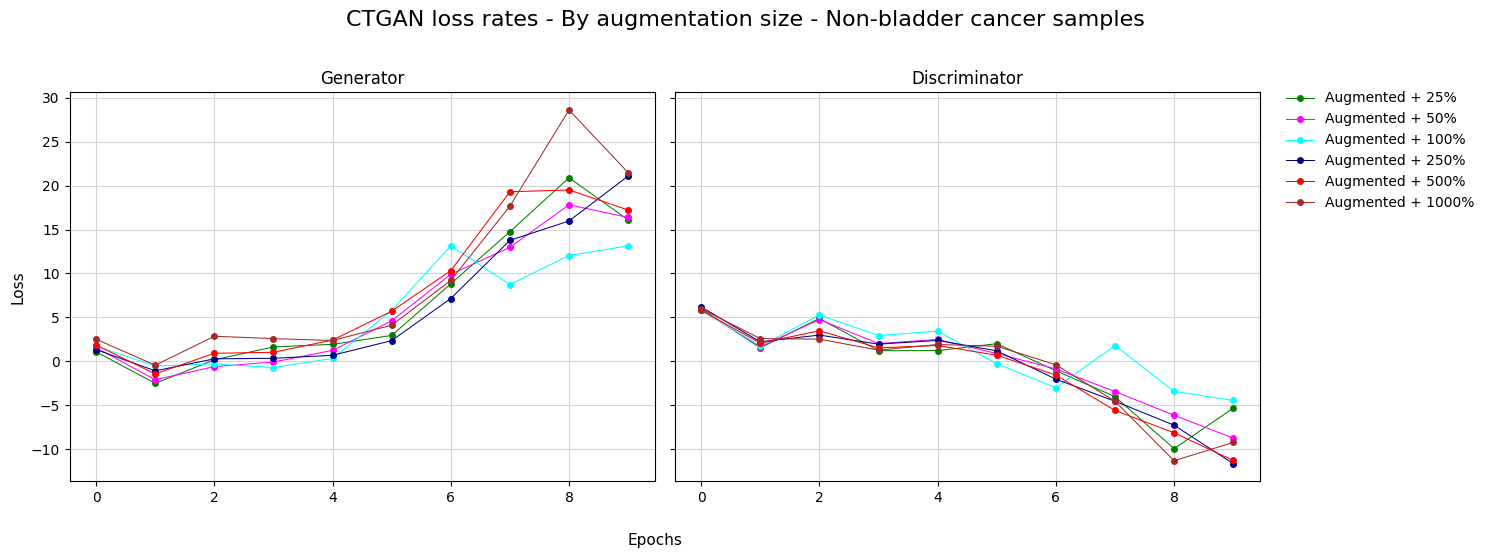

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

line_colors = ['green', 'magenta', 'cyan', 'darkblue', 'red', 'brown']

# Generator loss
axes[0].plot(loss_0_25['epoch'], loss_0_25['generator_loss'], label='Augmented + 25%', color=line_colors[0], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_0_50['epoch'], loss_0_50['generator_loss'], label='Augmented + 50%', color=line_colors[1], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_0_100['epoch'], loss_0_100['generator_loss'], label='Augmented + 100%', color=line_colors[2], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_0_250['epoch'], loss_0_250['generator_loss'], label='Augmented + 250%', color=line_colors[3], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_0_500['epoch'], loss_0_500['generator_loss'], label='Augmented + 500%', color=line_colors[4], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_0_1000['epoch'], loss_0_1000['generator_loss'], label='Augmented + 1000%', color=line_colors[5], marker='o', markersize=4, linewidth=0.75)
axes[0].set_title('Generator')
#axes[0].set_xlabel('Epoch',fontsize=11)
axes[0].set_ylabel('Loss',fontsize=11)
#axes[0].legend(frameon=False)
axes[0].grid(True,color='lightgrey')

# Discriminator loss
axes[1].plot(loss_0_25['epoch'], loss_0_25['critic_loss'], label='Augmented + 25%', color=line_colors[0], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_0_50['epoch'], loss_0_50['critic_loss'], label='Augmented + 50%', color=line_colors[1], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_0_100['epoch'], loss_0_100['critic_loss'], label='Augmented + 100%', color=line_colors[2], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_0_250['epoch'], loss_0_250['critic_loss'], label='Augmented + 250%', color=line_colors[3], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_0_500['epoch'], loss_0_500['critic_loss'], label='Augmented + 500%', color=line_colors[4], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_0_1000['epoch'], loss_0_1000['critic_loss'], label='Augmented + 1000%', color=line_colors[5], marker='o', markersize=4, linewidth=0.75)
axes[1].set_title('Discriminator')
#axes[1].set_xlabel('Epoch',fontsize=11)
#axes[1].set_ylabel('Loss',fontsize=11)
axes[1].legend(frameon=False,loc='upper left', bbox_to_anchor=(1, 1.07), borderaxespad=1.5)
axes[1].grid(True,color='lightgrey')

fig.suptitle('CTGAN loss rates - By augmentation size - Non-bladder cancer samples', y=1.02, fontsize=16)
fig.text(0.44, -0.05, 'Epochs', ha='center', fontsize=11)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()


#### 9.2. Class 1 - Bladder cancer

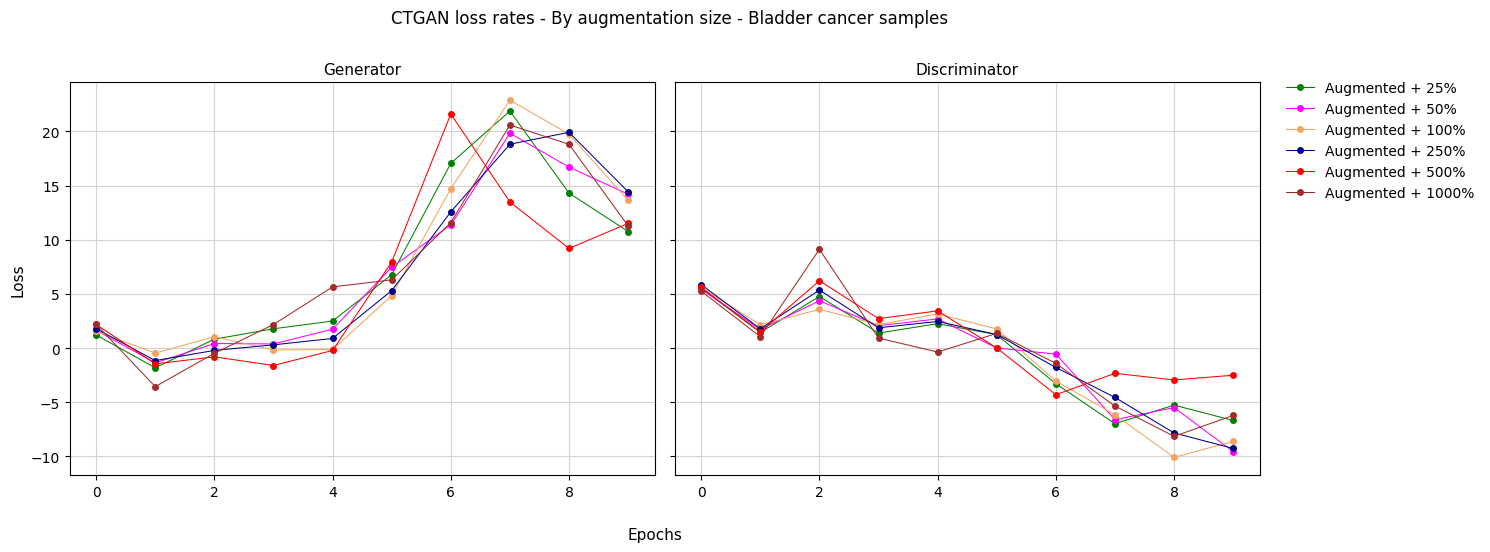

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

line_colors = ['green', 'magenta', 'sandybrown', 'darkblue', 'red', 'brown']

# Generator loss
axes[0].plot(loss_1_25['epoch'], loss_1_25['generator_loss'], label='Augmented + 25%', color=line_colors[0], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_1_50['epoch'], loss_1_50['generator_loss'], label='Augmented + 50%', color=line_colors[1], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_1_100['epoch'], loss_1_100['generator_loss'], label='Augmented + 100%', color=line_colors[2], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_1_250['epoch'], loss_1_250['generator_loss'], label='Augmented + 250%', color=line_colors[3], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_1_500['epoch'], loss_1_500['generator_loss'], label='Augmented + 500%', color=line_colors[4], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_1_1000['epoch'], loss_1_1000['generator_loss'], label='Augmented + 1000%', color=line_colors[5], marker='o', markersize=4, linewidth=0.75)
axes[0].set_title('Generator',fontsize=11)
#axes[0].set_xlabel('Epoch',fontsize=11)
axes[0].set_ylabel('Loss',fontsize=11)
#axes[0].legend(frameon=False)
axes[0].grid(True,color='lightgrey')

# Discriminator loss
axes[1].plot(loss_1_25['epoch'], loss_1_25['critic_loss'], label='Augmented + 25%', color=line_colors[0], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_1_50['epoch'], loss_1_50['critic_loss'], label='Augmented + 50%', color=line_colors[1], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_1_100['epoch'], loss_1_100['critic_loss'], label='Augmented + 100%', color=line_colors[2], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_1_250['epoch'], loss_1_250['critic_loss'], label='Augmented + 250%', color=line_colors[3], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_1_500['epoch'], loss_1_500['critic_loss'], label='Augmented + 500%', color=line_colors[4], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_1_1000['epoch'], loss_1_1000['critic_loss'], label='Augmented + 1000%', color=line_colors[5], marker='o', markersize=4, linewidth=0.75)
axes[1].set_title('Discriminator',fontsize=11)
#axes[1].set_xlabel('Epoch',fontsize=11)
#axes[1].set_ylabel('Loss',fontsize=11)
axes[1].legend(frameon=False,loc='upper left', bbox_to_anchor=(1, 1.07), borderaxespad=1.5)
axes[1].grid(True,color='lightgrey')

fig.suptitle('CTGAN loss rates - By augmentation size - Bladder cancer samples', x=0.45, y=1.01)
fig.text(0.44, -0.05, 'Epochs', ha='center', fontsize=11)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()

#### 9.3. Selected augmented dataset

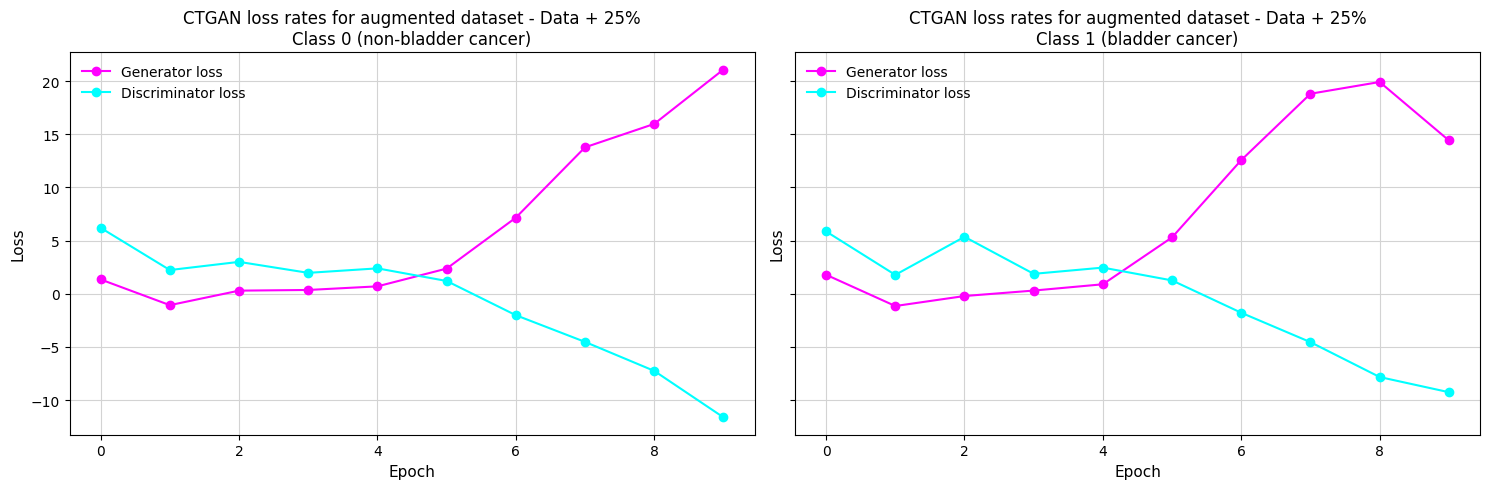

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

# loss_0_250
axes[0].plot(loss_0_250['epoch'], loss_0_250['generator_loss'], label='Generator loss', color='magenta', marker='o')
axes[0].plot(loss_0_250['epoch'], loss_0_250['critic_loss'], label='Discriminator loss', color='cyan', marker='o')
axes[0].set_title('CTGAN loss rates for augmented dataset - Data + 25%\nClass 0 (non-bladder cancer)')
axes[0].set_xlabel('Epoch',fontsize=11)
axes[0].set_ylabel('Loss',fontsize=11)
axes[0].legend(frameon=False)
axes[0].grid(True,color='lightgrey')

# loss_1_250
axes[1].plot(loss_1_250['epoch'], loss_1_250['generator_loss'], label='Generator loss', color='magenta', marker='o')
axes[1].plot(loss_1_250['epoch'], loss_1_250['critic_loss'], label='Discriminator loss', color='cyan', marker='o')
axes[1].set_title('CTGAN loss rates for augmented dataset - Data + 25%\nClass 1 (bladder cancer)')
axes[1].set_xlabel('Epoch',fontsize=11)
axes[1].set_ylabel('Loss',fontsize=11)
axes[1].legend(frameon=False)
axes[1].grid(True,color='lightgrey')

plt.tight_layout()

# Show the plots
plt.show()


### 10. Analysis : Stability of CTGAN
Calculate the variability in fidelity scores over multiple (5) iterations using the same hyperparameters for each augmentation scenario

#### 10.1 Calculate variability in the fidelity scores
Standard deviation is sensitive to the scale of the data so will use the coefficient of variation which normalizes by the mean

In [ ]:
#_bal
stability_0_bal_a=stability_0_bal.drop(columns=['tot_num_0','tot_cat_0','tot_0'])
stability_0_bal_t=(stability_0_bal_a.std()/stability_0_bal_a.mean())
df_0_bal_a=pd.DataFrame({'metric':stability_0_bal_t.index, 'value':stability_0_bal_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

stability_1_bal_a=stability_1_bal.drop(columns=['tot_num_1','tot_cat_1','tot_1'])
stability_1_bal_t=(stability_1_bal_a.std()/stability_1_bal_a.mean())
df_1_bal_a=pd.DataFrame({'metric':stability_1_bal_t.index, 'value':stability_1_bal_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

# _25
stability_0_25_a=stability_0_25.drop(columns=['tot_num_0','tot_cat_0','tot_0'])
stability_0_25_t=(stability_0_25_a.std()/stability_0_25_a.mean())
df_0_25_a = pd.DataFrame({'metric':stability_0_25_t.index, 'value':stability_0_25_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

stability_1_25_a=stability_1_25.drop(columns=['tot_num_1','tot_cat_1','tot_1'])
stability_1_25_t=(stability_1_25_a.std()/stability_1_25_a.mean())
df_1_25_a=pd.DataFrame({'metric':stability_1_25_t.index, 'value':stability_1_25_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

# _50
stability_0_50_a=stability_0_50.drop(columns=['tot_num_0','tot_cat_0','tot_0'])
stability_0_50_t=(stability_0_50_a.std()/stability_0_50_a.mean())
df_0_50_a = pd.DataFrame({'metric':stability_0_50_t.index, 'value':stability_0_50_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

stability_1_50_a=stability_1_50.drop(columns=['tot_num_1','tot_cat_1','tot_1'])
stability_1_50_t=(stability_1_50_a.std()/stability_1_50_a.mean())
df_1_50_a=pd.DataFrame({'metric':stability_1_50_t.index, 'value':stability_1_50_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

# _100
stability_0_100_a=stability_0_100.drop(columns=['tot_num_0','tot_cat_0','tot_0'])
stability_0_100_t=(stability_0_100_a.std()/stability_0_100_a.mean())
df_0_100_a = pd.DataFrame({'metric':stability_0_100_t.index, 'value':stability_0_100_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

stability_1_100_a=stability_1_100.drop(columns=['tot_num_1','tot_cat_1','tot_1'])
stability_1_100_t=(stability_1_100_a.std()/stability_1_100_a.mean())
df_1_100_a=pd.DataFrame({'metric':stability_1_100_t.index, 'value':stability_1_100_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

# _250
stability_0_250_a=stability_0_250.drop(columns=['tot_num_0','tot_cat_0','tot_0'])
stability_0_250_t=(stability_0_250_a.std()/stability_0_250_a.mean())
df_0_250_a = pd.DataFrame({'metric':stability_0_250_t.index, 'value':stability_0_250_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

stability_1_250_a=stability_1_250.drop(columns=['tot_num_1','tot_cat_1','tot_1'])
stability_1_250_t=(stability_1_250_a.std()/stability_1_250_a.mean())
df_1_250_a=pd.DataFrame({'metric':stability_1_250_t.index, 'value':stability_1_250_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

# _500
stability_0_500_a=stability_0_500.drop(columns=['tot_num_0','tot_cat_0','tot_0'])
stability_0_500_t=(stability_0_500_a.std()/stability_0_500_a.mean())
df_0_500_a = pd.DataFrame({'metric':stability_0_500_t.index, 'value':stability_0_500_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

stability_1_500_a=stability_1_500.drop(columns=['tot_num_1','tot_cat_1','tot_1'])
stability_1_500_t=(stability_1_500_a.std()/stability_1_500_a.mean())
df_1_500_a=pd.DataFrame({'metric':stability_1_500_t.index, 'value':stability_1_500_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

# _500
stability_0_500_a=stability_0_500.drop(columns=['tot_num_0','tot_cat_0','tot_0'])
stability_0_500_t=(stability_0_500_a.std()/stability_0_500_a.mean())
df_0_500_a = pd.DataFrame({'metric':stability_0_500_t.index, 'value':stability_0_500_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

stability_1_500_a=stability_1_500.drop(columns=['tot_num_1','tot_cat_1','tot_1'])
stability_1_500_t=(stability_1_500_a.std()/stability_1_500_a.mean())
df_1_500_a=pd.DataFrame({'metric':stability_1_500_t.index, 'value':stability_1_500_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

# _1000
stability_0_1000_a=stability_0_1000.drop(columns=['tot_num_0','tot_cat_0','tot_0'])
stability_0_1000_t=(stability_0_1000_a.std()/stability_0_1000_a.mean())
df_0_1000_a = pd.DataFrame({'metric':stability_0_1000_t.index, 'value':stability_0_1000_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

stability_1_1000_a=stability_1_1000.drop(columns=['tot_num_1','tot_cat_1','tot_1'])
stability_1_1000_t=(stability_1_1000_a.std()/stability_1_1000_a.mean())
df_1_1000_a=pd.DataFrame({'metric':stability_1_1000_t.index, 'value':stability_1_1000_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

#### 10.2. Bring together all the variation coefficients

In [ ]:
# Class 0

#df_0_bal_b=df_0_bal_a.rename(columns={'metric':'Metric', 'value': 'Value:Bal'})
df_0_25_b=df_0_25_a.rename(columns={'metric':'Metric', 'value': 'Value:25%'})
df_0_50_b=df_0_50_a.rename(columns={'metric':'Metric', 'value': 'Value:50%'})
df_0_100_b=df_0_100_a.rename(columns={'metric':'Metric', 'value': 'Value:100%'})
df_0_250_b=df_0_250_a.rename(columns={'metric':'Metric', 'value': 'Value:250%'})
df_0_500_b=df_0_500_a.rename(columns={'metric':'Metric', 'value': 'Value:500%'})
df_0_1000_b=df_0_1000_a.rename(columns={'metric':'Metric', 'value': 'Value:1000%'})
#df_0_alla=pd.concat([df_0_bal_b, df_0_25_b['Value:25%'], df_0_50_b['Value:50%'], df_0_100_b['Value:100%'], df_0_250_b['Value:250%'], df_0_500_b['Value:500%'], df_0_1000_b['Value:1000%']], axis=1)
df_0_alla=pd.concat([df_0_25_b, df_0_50_b['Value:50%'], df_0_100_b['Value:100%'], df_0_250_b['Value:250%'], df_0_500_b['Value:500%'], df_0_1000_b['Value:1000%']], axis=1)
replace_dic2={'pcd_0':'PCD score', 'mmd_0':'MMD score', 'kld_0':'KLD score', 'gen_0':'Gender distn', 'hyp_0':'Hypertension distn', 'dia_0':'Diabetes distn', 'smo_0':'Smoking distn', 'dri_0':'Drinking distn', 'bee_0':'Bee1leNu1 distn'}
df_0_alla['Metric']=df_0_alla['Metric'].replace(replace_dic2)
df_0_alla

,Metric,Value:25%,Value:50%,Value:100%,Value:250%,Value:500%,Value:1000%
0,PCD score,0.039506,0.054732,0.009439,0.047842,0.039971,0.066503
1,MMD score,0.366680,0.188460,0.215541,0.222718,0.355576,0.275529
2,KLD score,0.227555,0.229671,0.298903,0.256800,0.403062,0.303145
3,Gender distn,0.219871,0.520653,0.524534,0.452484,0.894180,0.518881
4,Drinking distn,0.535419,0.792702,0.604950,0.935653,0.734559,0.662539
5,Smoking distn,0.805727,1.000126,0.918559,1.230402,0.432413,0.547723
6,Diabetes distn,0.589746,1.080289,1.026256,0.509325,0.993808,0.355507
7,Hypertension distn,0.359146,0.550841,0.548743,0.743879,0.670153,0.798501
8,Bee1leNu1 distn,0.329973,0.403767,0.212167,0.187083,0.216378,0.430116


In [ ]:
# Class 1

df_1_bal_b=df_1_bal_a.rename(columns={'metric':'Metric', 'value': 'Value:Bal'})
df_1_25_b=df_1_25_a.rename(columns={'metric':'Metric', 'value': 'Value:25%'})
df_1_50_b=df_1_50_a.rename(columns={'metric':'Metric', 'value': 'Value:50%'})
df_1_100_b=df_1_100_a.rename(columns={'metric':'Metric', 'value': 'Value:100%'})
df_1_250_b=df_1_250_a.rename(columns={'metric':'Metric', 'value': 'Value:250%'})
df_1_500_b=df_1_500_a.rename(columns={'metric':'Metric', 'value': 'Value:500%'})
df_1_1000_b=df_1_1000_a.rename(columns={'metric':'Metric', 'value': 'Value:1000%'})
#df_1_alla=pd.concat([df_1_bal_b, df_1_25_b['Value:25%'], df_1_50_b['Value:50%'], df_1_100_b['Value:100%'], df_1_250_b['Value:250%'], df_1_500_b['Value:500%'], df_1_1000_b['Value:1000%']], axis=1)
df_1_alla=pd.concat([df_1_25_b, df_1_50_b['Value:50%'], df_1_100_b['Value:100%'], df_1_250_b['Value:250%'], df_1_500_b['Value:500%'], df_1_1000_b['Value:1000%']], axis=1)
replace_dic2={'pcd_1':'PCD score', 'mmd_1':'MMD score', 'kld_1':'KLD score', 'gen_1':'Gender distn', 'hyp_1':'Hypertension distn', 'dia_1':'Diabetes distn', 'smo_1':'Smoking distn', 'dri_1':'Drinking distn', 'bee_1':'Bee1leNu1 distn'}
df_1_alla['Metric']=df_1_alla['Metric'].replace(replace_dic2)
df_1_alla

,Metric,Value:25%,Value:50%,Value:100%,Value:250%,Value:500%,Value:1000%
0,PCD score,0.024838,0.024554,0.023166,0.017987,0.018779,0.040845
1,MMD score,0.284702,0.300242,0.338700,0.355523,0.064937,0.174938
2,KLD score,0.151662,0.162463,0.109720,0.243171,0.295075,0.291148
3,Gender distn,0.280222,0.431326,0.589527,0.461612,0.390199,0.546514
4,Drinking distn,0.339164,0.757662,0.852533,1.135136,0.985725,1.048563
5,Smoking distn,0.173896,0.640753,1.164455,1.027936,1.020957,0.699503
6,Diabetes distn,0.217061,1.030402,1.174215,0.900315,1.094362,0.964203
7,Hypertension distn,0.396583,0.766777,0.566212,0.632478,1.324135,0.453945
8,Bee1leNu1 distn,0.127477,0.740100,0.478766,0.847865,0.418805,0.508923


#### 10.3. Radar plots of variation coefficients for each class

##### 10.3.1. Class 0 - non-bladder cancer

In [ ]:
categories = ['PCD','MMD','KLD','Gender','Drinking','Smoking','Diabe1es','Hyper1en1ion','Bee1leNu1']
categories = [*categories, categories[0]]

#df_0_bal_values = df_0_bal_a['value']
df_0_25_values = df_0_25_a['value']
df_0_50_values = df_0_50_a['value']
df_0_100_values = df_0_100_a['value']
df_0_250_values = df_0_250_a['value']
df_0_500_values = df_0_500_a['value']
df_0_1000_values = df_0_1000_a['value']

#df_0_bal_values = [*df_0_bal_values, df_0_bal_values[0]]
df_0_25_values = [*df_0_25_values, df_0_25_values[0]]
df_0_50_values = [*df_0_50_values, df_0_50_values[0]]
df_0_100_values = [*df_0_100_values, df_0_100_values[0]]
df_0_250_values = [*df_0_250_values, df_0_250_values[0]]
df_0_500_values = [*df_0_500_values, df_0_500_values[0]]
df_0_1000_values = [*df_0_1000_values, df_0_1000_values[0]]

line_colors = ['green', 'magenta', 'cyan', 'darkblue', 'red', 'brown']

fig = go.Figure(
    #data=[go.Scatterpolar(r=df_0_bal_values, theta=categories, name='Balanced', line_color=line_colors[0]),
    data=[go.Scatterpolar(r=df_0_25_values, theta=categories, name='Augmented + 25%', line_color=line_colors[0]),
          go.Scatterpolar(r=df_0_50_values, theta=categories, name='Augmented + 50%', line_color=line_colors[1]),
          go.Scatterpolar(r=df_0_100_values, theta=categories, name='Augmented + 100%', line_color=line_colors[2]),
          go.Scatterpolar(r=df_0_250_values, theta=categories, name='Augmented + 250%', line_color=line_colors[3]),
          go.Scatterpolar(r=df_0_500_values, theta=categories, name='Augmented + 500%', line_color=line_colors[4]),
          go.Scatterpolar(r=df_0_1000_values, theta=categories, name='Augmented + 1,000%', line_color=line_colors[5])],
    layout=go.Layout(title=go.layout.Title(text='CTGAN performance variability - normalized scores - 5 iterations - Non-bladder cancer'),
                     polar={'radialaxis': {'visible': True, 'gridcolor': 'rgba(0, 0, 0, 0.1)'},
                            'angularaxis': {'visible': True, 'gridcolor': 'rgba(0, 0, 0, 0.1)'}},
                     legend=dict(x=1.25, y=0.63),
                     showlegend=True))

# Adjust the left margin to move the plot to the left
fig.update_layout(margin=dict(r=1200), # Position of plot (pixels)
                  title=dict(x=0, y=0.68),
                  height=1500, width=1700) # Size of the plot
pyo.iplot(fig)

##### 10.3.2. Class 1 - bladder cancer

In [ ]:
categories = ['PCD','MMD','KLD','Gender','Drinking','Smoking','Diabe1es','Hyper1en1ion','Bee1leNu1']
categories = [*categories, categories[0]]

#df_1_bal_values = df_1_bal_a['value']
df_1_25_values = df_1_25_a['value']
df_1_50_values = df_1_50_a['value']
df_1_100_values = df_1_100_a['value']
df_1_250_values = df_1_250_a['value']
df_1_500_values = df_1_500_a['value']
df_1_1000_values = df_1_1000_a['value']

#df_1_bal_values = [*df_1_bal_values, df_1_bal_values[0]]
df_1_25_values = [*df_1_25_values, df_1_25_values[0]]
df_1_50_values = [*df_1_50_values, df_1_50_values[0]]
df_1_100_values = [*df_1_100_values, df_1_100_values[0]]
df_1_250_values = [*df_1_250_values, df_1_250_values[0]]
df_1_500_values = [*df_1_500_values, df_1_500_values[0]]
df_1_1000_values = [*df_1_1000_values, df_1_1000_values[0]]

line_colors = ['green', 'magenta', 'cyan', 'darkblue', 'red', 'brown']

fig = go.Figure(
    #data=[go.Scatterpolar(r=df_1_bal_values, theta=categories, name='Balanced', line_color=line_colors[0]),
    data=[go.Scatterpolar(r=df_1_25_values, theta=categories, name='Augmented + 25%', line_color=line_colors[0]),
          go.Scatterpolar(r=df_1_50_values, theta=categories, name='Augmented + 50%', line_color=line_colors[1]),
          go.Scatterpolar(r=df_1_100_values, theta=categories, name='Augmented + 100%', line_color=line_colors[2]),
          go.Scatterpolar(r=df_1_250_values, theta=categories, name='Augmented + 250%', line_color=line_colors[3]),
          go.Scatterpolar(r=df_1_500_values, theta=categories, name='Augmented + 500%', line_color=line_colors[4]),
          go.Scatterpolar(r=df_1_1000_values, theta=categories, name='Augmented + 1,000%', line_color=line_colors[5])],
    layout=go.Layout(title=go.layout.Title(text='CTGAN performance variability - normalized scores - 5 iterations - Bladder cancer'),
                     polar={'radialaxis': {'visible': True, 'gridcolor': 'rgba(0, 0, 0, 0.1)'},
                            'angularaxis': {'visible': True, 'gridcolor': 'rgba(0, 0, 0, 0.1)'}},
                     legend=dict(x=1.25, y=0.63),
                     showlegend=True))

# Adjust the left margin to move the plot to the left
fig.update_layout(margin=dict(r=1200), # Position of plot (pixels)
                  title=dict(x=0, y=0.68),
                  height=1500, width=1700) # Size of the plot
pyo.iplot(fig)

##### 10.3.3. Subplots approach

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'polar'}] * 2] * 1)

categories = ['PCD score','MMD score','KLD score','Gender distn','Drinking distn','Smoking distn','Diabe1es distn','Hyper1en1ion distn','Bee1leNu1 distn']
categories = [*categories, categories[0]]

df_0_bal_values = df_0_bal_a['value']
df_0_25_values = df_0_25_a['value']
df_0_50_values = df_0_50_a['value']
df_0_100_values = df_0_100_a['value']
df_0_250_values = df_0_250_a['value']
df_0_500_values = df_0_500_a['value']
df_0_1000_values = df_0_1000_a['value']

df_0_bal_values = [*df_0_bal_values, df_0_bal_values[0]]
df_0_25_values = [*df_0_25_values, df_0_25_values[0]]
df_0_50_values = [*df_0_50_values, df_0_50_values[0]]
df_0_100_values = [*df_0_100_values, df_0_100_values[0]]
df_0_250_values = [*df_0_250_values, df_0_250_values[0]]
df_0_500_values = [*df_0_500_values, df_0_500_values[0]]
df_0_1000_values = [*df_0_1000_values, df_0_1000_values[0]]

df_1_bal_values = df_1_bal_a['value']
df_1_25_values = df_1_25_a['value']
df_1_50_values = df_1_50_a['value']
df_1_100_values = df_1_100_a['value']
df_1_250_values = df_1_250_a['value']
df_1_500_values = df_1_500_a['value']
df_1_1000_values = df_1_1000_a['value']

df_1_bal_values = [*df_1_bal_values, df_1_bal_values[0]]
df_1_25_values = [*df_1_25_values, df_1_25_values[0]]
df_1_50_values = [*df_1_50_values, df_1_50_values[0]]
df_1_100_values = [*df_1_100_values, df_1_100_values[0]]
df_1_250_values = [*df_1_250_values, df_1_250_values[0]]
df_1_500_values = [*df_1_500_values, df_1_500_values[0]]
df_1_1000_values = [*df_1_1000_values, df_1_1000_values[0]]

line_colors = ['green', 'magenta', 'cyan', 'darkblue', 'red', 'brown']

##### First plot - class 0

# _bal
# fig.add_trace(go.Scatterpolar(theta=categories,r=df_0_bal_values,name='Balanced data', showlegend=False),
#               row=1,
#               col=1)
# _25
fig.add_trace(go.Scatterpolar(theta=categories,r=df_0_25_values,name='Augmented +25%', showlegend=False, line_color=line_colors[0]),
              row=1,
              col=1)
# _50
fig.add_trace(go.Scatterpolar(theta=categories,r=df_0_50_values,name='Augmented +50%', showlegend=False, line_color=line_colors[1]),
              row=1,
              col=1)
# _100
fig.add_trace(go.Scatterpolar(theta=categories,r=df_0_100_values,name='Augmented +100%', showlegend=False, line_color=line_colors[2]),
              row=1,
              col=1)
# _250
fig.add_trace(go.Scatterpolar(theta=categories,r=df_0_250_values,name='Augmented +250%', showlegend=False, line_color=line_colors[3]),
              row=1,
              col=1)
# _500
fig.add_trace(go.Scatterpolar(theta=categories,r=df_0_500_values,name='Augmented +500%', showlegend=False, line_color=line_colors[4]),
              row=1,
              col=1)
# _1000
fig.add_trace(go.Scatterpolar(theta=categories,r=df_0_1000_values,name='Augmented +1000%', showlegend=False, line_color=line_colors[5]),
              row=1,
              col=1)

##### Second plot - class 1

# _bal
# fig.add_trace(go.Scatterpolar(theta=categories,r=df_1_bal_values,name='Balanced data'),
#               row=1,
#               col=2)
# _25
fig.add_trace(go.Scatterpolar(theta=categories,r=df_1_25_values,name='Augmented +25%', line_color=line_colors[0]),
              row=1,
              col=2)
# _50
fig.add_trace(go.Scatterpolar(theta=categories,r=df_1_50_values,name='Augmented +50%', line_color=line_colors[1]),
              row=1,
              col=2)
# _100
fig.add_trace(go.Scatterpolar(theta=categories,r=df_1_100_values,name='Augmented +100%', line_color=line_colors[2]),
              row=1,
              col=2)
# _250
fig.add_trace(go.Scatterpolar(theta=categories,r=df_1_250_values,name='Augmented +250%', line_color=line_colors[3]),
              row=1,
              col=2)
# _500
fig.add_trace(go.Scatterpolar(theta=categories,r=df_1_500_values,name='Augmented +500%', line_color=line_colors[4]),
              row=1,
              col=2)
# _1000
fig.add_trace(go.Scatterpolar(theta=categories,r=df_1_1000_values,name='Augmented +1000%', line_color=line_colors[5]),
              row=1,
              col=2)

# Update layout for the first polar subplot
fig.update_polars(dict(radialaxis=dict(tickvals=[0, 0.2, 0.4, 0.6, 0.8, 1], ticktext=['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])),
                  row=1, col=1)

# Update layout for the second polar subplot
fig.update_polars(dict(radialaxis=dict(tickvals=[0, 0.2, 0.4, 0.6, 0.8, 1], ticktext=['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])),
                  row=1, col=2)

# Update common layout settings
fig.update_layout(title_text="CTGAN reliability - variability in performance metrics (normalized)",
                  title_font_size=20,
                  title_y=0.98,
                  annotations=[dict(text="Non-bladder cancer",x=0.18, y=-0.25, xref="paper", yref="paper", showarrow=False, font=dict(size=17)),
                               dict(text="Bladder cancer", x=0.81, y=-0.25, xref="paper", yref="paper", showarrow=False, font=dict(size=17))])
# Show the plot
fig.show()

### 11. Analysis : Feature distribution analysis - real versus synthetic


#### 11.1. Get real and synthetic data per augmentation scenario

In [ ]:
# Real data by class from above
df_imp_t_0=df_t_0.copy()
df_imp_t_1=df_t_1.copy()

# Get synthetic data by scenario and class
#train_bal_df_synth_0=aug_bal.loc[(aug_bal['disease1']==0) & (aug_bal['type']=='synth')].drop(columns=['type'],axis=1)
#train_bal_df_synth_1=aug_bal.loc[(aug_bal['disease1']==1) & (aug_bal['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_25_df_synth_0=aug_25.loc[(aug_25['disease1']==0) & (aug_25['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_25_df_synth_1=aug_25.loc[(aug_25['disease1']==1) & (aug_25['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_50_df_synth_0=aug_50.loc[(aug_50['disease1']==0) & (aug_50['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_50_df_synth_1=aug_50.loc[(aug_50['disease1']==1) & (aug_50['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_100_df_synth_0=aug_100.loc[(aug_100['disease1']==0) & (aug_100['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_100_df_synth_1=aug_100.loc[(aug_100['disease1']==1) & (aug_100['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_250_df_synth_0=aug_250.loc[(aug_250['disease1']==0) & (aug_250['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_250_df_synth_1=aug_250.loc[(aug_250['disease1']==1) & (aug_250['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_500_df_synth_0=aug_500.loc[(aug_500['disease1']==0) & (aug_500['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_500_df_synth_1=aug_500.loc[(aug_500['disease1']==1) & (aug_500['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_1000_df_synth_0=aug_1000.loc[(aug_1000['disease1']==0) & (aug_1000['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_1000_df_synth_1=aug_1000.loc[(aug_1000['disease1']==1) & (aug_1000['type']=='synth')].drop(columns=['type'],axis=1)

data_0 = pd.concat([df_imp_t_0.assign(Group='Real'),
                    #train_bal_df_synth_0.assign(Group='Bal'),
                    train_bal_25_df_synth_0.assign(Group='+25%'),
                    train_bal_50_df_synth_0.assign(Group='+50%'),
                    train_bal_100_df_synth_0.assign(Group='+100%'),
                    train_bal_250_df_synth_0.assign(Group='+250%'),
                    train_bal_500_df_synth_0.assign(Group='+500%'),
                    train_bal_1000_df_synth_0.assign(Group='+1,000%')])

data_1 = pd.concat([df_imp_t_1.assign(Group='Real'),
                    #train_bal_df_synth_1.assign(Group='Bal'),
                    train_bal_25_df_synth_1.assign(Group='+25%'),
                    train_bal_50_df_synth_1.assign(Group='+50%'),
                    train_bal_100_df_synth_1.assign(Group='+100%'),
                    train_bal_250_df_synth_1.assign(Group='+250%'),
                    train_bal_500_df_synth_1.assign(Group='+500%'),
                    train_bal_1000_df_synth_1.assign(Group='+1,000%')])

#### 11.2. Create visual comparison plots - real vs. synthetic for each feature across augmentation scenarios

In [ ]:
# Set up subplots
fig, axes=plt.subplots(36,2,figsize=(30,280))

# Over-arching title of all plots
fig.suptitle('All augmented datasets - synthetic versus real - distribution of sample values',fontsize=24,y=1)

# Set a text font size scaling factor to make all text readable
sns.set(font_scale=1.25)

# Plot for each feature
stackplot_all_aug('gender','Male','Female',0)

box_whisk_plot('Group','age',data_0,'age - non-bladder cancer',1,0)
box_whisk_plot('Group','age',data_1,'age - bladder cancer',1,1)

stackplot_all_aug('smoking','Non-smoker','Smoker',2)
stackplot_all_aug('drinking','Non-drinker','Drinker',3)
stackplot_all_aug('diabe1es','Non-diabetic','Diabetic',4)
stackplot_all_aug('hyper1en1ion','Non-hypertension','Hypertension',5)
stackplot_all_aug('bee1lenu1','Non-bee1lenu1','bee1lenu1',6)

box_whisk_plot('Group','albumin',data_0,'albumin - non-bladder cancer',7,0)
box_whisk_plot('Group','albumin',data_1,'albumin - bladder cancer',7,1)

box_whisk_plot('Group','alk',data_0,'alk - non-bladder cancer',8,0)
box_whisk_plot('Group','alk',data_1,'alk - bladder cancer',8,1)

box_whisk_plot('Group','alt_gpt',data_0,'alt_gpt - non-bladder cancer',9,0)
box_whisk_plot('Group','alt_gpt',data_1,'alt_gpt - bladder cancer',9,1)

box_whisk_plot('Group','ast_got',data_0,'ast_got - non-bladder cancer',10,0)
box_whisk_plot('Group','ast_got',data_1,'ast_got - bladder cancer',10,1)

box_whisk_plot('Group','bun',data_0,'bun - non-bladder cancer',11,0)
box_whisk_plot('Group','bun',data_1,'bun - bladder cancer',11,1)

box_whisk_plot('Group','calcium',data_0,'calcium - non-bladder cancer',12,0)
box_whisk_plot('Group','calcium',data_1,'calcium - bladder cancer',12,1)

box_whisk_plot('Group','chloride',data_0,'chloride - non-bladder cancer',13,0)
box_whisk_plot('Group','chloride',data_1,'chloride - bladder cancer',13,1)

box_whisk_plot('Group','creatinine',data_0,'creatinine - non-bladder cancer',14,0)
box_whisk_plot('Group','creatinine',data_1,'creatinine - bladder cancer',14,1)

box_whisk_plot('Group','direct_bilirubin',data_0,'direct_bilirubin - non-bladder cancer',15,0)
box_whisk_plot('Group','direct_bilirubin',data_1,'direct_bilirubin - bladder cancer',15,1)

box_whisk_plot('Group','estimated_gfr',data_0,'estimated_gfr - non-bladder cancer',16,0)
box_whisk_plot('Group','estimated_gfr',data_1,'estimated_gfr - bladder cancer',16,1)

box_whisk_plot('Group','glucose_ac',data_0,'glucose_ac - non-bladder cancer',17,0)
box_whisk_plot('Group','glucose_ac',data_1,'glucose_ac - bladder cancer',17,1)

box_whisk_plot('Group','nitrite',data_0,'nitrite - non-bladder cancer',18,0)
box_whisk_plot('Group','nitrite',data_1,'nitrite - bladder cancer',18,1)

box_whisk_plot('Group','urine_occult_blood',data_0,'urine_occult_blood - non-bladder cancer',19,0)
box_whisk_plot('Group','urine_occult_blood',data_1,'urine_occult_blood - bladder cancer',19,1)

box_whisk_plot('Group','ph',data_0,'ph - non-bladder cancer',20,0)
box_whisk_plot('Group','ph',data_1,'ph - bladder cancer',20,1)

box_whisk_plot('Group','potassium',data_0,'potassium - non-bladder cancer',21,0)
box_whisk_plot('Group','potassium',data_1,'potassium - bladder cancer',21,1)

box_whisk_plot('Group','sodium',data_0,'sodium - non-bladder cancer',22,0)
box_whisk_plot('Group','sodium',data_1,'sodium - bladder cancer',22,1)

box_whisk_plot('Group','specific_gravity',data_0,'specific_gravity - non-bladder cancer',23,0)
box_whisk_plot('Group','specific_gravity',data_1,'specific_gravity - bladder cancer',23,1)

box_whisk_plot('Group','strip_wbc',data_0,'strip_wbc - non-bladder cancer',24,0)
box_whisk_plot('Group','strip_wbc',data_1,'strip_wbc - bladder cancer',24,1)

box_whisk_plot('Group','total_bilirubin',data_0,'total_bilirubin - non-bladder cancer',25,0)
box_whisk_plot('Group','total_bilirubin',data_1,'total_bilirubin - bladder cancer',25,1)

box_whisk_plot('Group','total_cholesterol',data_0,'total_cholesterol - non-bladder cancer',26,0)
box_whisk_plot('Group','total_cholesterol',data_1,'total_cholesterol - bladder cancer',26,1)

box_whisk_plot('Group','total_protein',data_0,'total_protein - non-bladder cancer',27,0)
box_whisk_plot('Group','total_protein',data_1,'total_protein - bladder cancer',27,1)

box_whisk_plot('Group','triglyceride',data_0,'triglyceride - non-bladder cancer',28,0)
box_whisk_plot('Group','triglyceride',data_1,'triglyceride - bladder cancer',28,1)

box_whisk_plot('Group','urine_epithelium_count',data_0,'urine_epithelium_count - non-bladder cancer',29,0)
box_whisk_plot('Group','urine_epithelium_count',data_1,'urine_epithelium_count - bladder cancer',29,1)

box_whisk_plot('Group','uric_acid',data_0,'uric_acid - non-bladder cancer',30,0)
box_whisk_plot('Group','uric_acid',data_1,'uric_acid - bladder cancer',30,1)

box_whisk_plot('Group','urine_bilirubin',data_0,'urine_bilirubin - non-bladder cancer',31,0)
box_whisk_plot('Group','urine_bilirubin',data_1,'urine_bilirubin - bladder cancer',31,1)

box_whisk_plot('Group','urine_glucose',data_0,'urine_glucose - non-bladder cancer',32,0)
box_whisk_plot('Group','urine_glucose',data_1,'urine_glucose - bladder cancer',32,1)

box_whisk_plot('Group','urine_ketone',data_0,'urine_ketone - non-bladder cancer',33,0)
box_whisk_plot('Group','urine_ketone',data_1,'urine_ketone - bladder cancer',33,1)

box_whisk_plot('Group','urine_protein',data_0,'urine_protein - non-bladder cancer',34,0)
box_whisk_plot('Group','urine_protein',data_1,'urine_protein - bladder cancer',34,1)

box_whisk_plot('Group','urobilinogen',data_0,'urobilinogen - non-bladder cancer',35,0)
box_whisk_plot('Group','urobilinogen',data_1,'urobilinogen - bladder cancer',35,1)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### 12. Analysis : Feature correlations - real versus synthetic

- Again, using the augmented datasets with the best fidelity from each augmentation scenario
- Only considers continuous features
- As per in the EDA use Spearman rank correlation coefficient method as:
  - Measures the monotonic relationship between two variables (whether the relationship is strictly increasing or decreasing)
  - Does not assume linearity or normal distribution
  - Less sensitive to outliers than Pearson correlation
  - Suitable for both continuous and ordinal (rank-ordered)

#### 12.1 Calculate the correlations within each augmented dataset and compare with real data - 'non-bladder cancer' class

In [ ]:
# Real data by class from above
#df_imp_t_0
#df_imp_t_1

# Synthetic data by scenario and class from above
# train_bal_df_synth_0
# train_bal_25_df_synth_0
# train_bal_50_df_synth_0
# train_bal_100_df_synth_0
# train_bal_250_df_synth_0
# train_bal_500_df_synth_0
# train_bal_1000_df_synth_0

# train_bal_df_synth_1
# train_bal_25_df_synth_1
# train_bal_50_df_synth_1
# train_bal_100_df_synth_1
# train_bal_250_df_synth_1
# train_bal_500_df_synth_1
# train_bal_1000_df_synth_1

In [ ]:
# Set up subplots
fig, axes=plt.subplots(6,2,figsize=(80,200),constrained_layout=True)

# Over-arching title of all plots
fig.suptitle('Spearman rank correlation coefficents - synthetic versus real - non-bladder cancer - transformed data \n (-1=perfect negative monotonic relationship, 1=perfect positive monotonic relationship)',fontsize=60,y=1.02)

# Real data vs balanced synthetic data
corr_0=df_imp_t_0.corr(method='spearman')
# heatmap_plot(corr_0,'Real data',0,0)
# corr_0a=train_bal_df_synth_0.corr(method='spearman')
# heatmap_plot(corr_0a,'Synthetic balanced data',0,1)

# Real data vs +25% synthetic data
heatmap_plot(corr_0,'Real data',0,0) # By removing 'Bal' had to change all the subplot position for the remaining plots
corr_0b=train_bal_25_df_synth_0.corr(method='spearman')
heatmap_plot(corr_0b,'Synthetic +25% data',0,1)

# Real data vs +50% synthetic data
heatmap_plot(corr_0,'Real data',1,0)
corr_0c=train_bal_50_df_synth_0.corr(method='spearman')
heatmap_plot(corr_0c,'Synthetic +50% data',1,1)

# Real data vs +100% synthetic data
heatmap_plot(corr_0,'Real data',2,0)
corr_0d=train_bal_100_df_synth_0.corr(method='spearman')
heatmap_plot(corr_0d,'Synthetic +100% data',2,1)

# Real data vs +250% synthetic data
heatmap_plot(corr_0,'Real data',3,0)
corr_0e=train_bal_250_df_synth_0.corr(method='spearman')
heatmap_plot(corr_0e,'Synthetic +250% data',3,1)

# Real data vs +500% synthetic data
heatmap_plot(corr_0,'Real data',4,0)
corr_0f=train_bal_500_df_synth_0.corr(method='spearman')
heatmap_plot(corr_0f,'Synthetic +500% data',4,1)

# Real data vs +1,000% synthetic data
heatmap_plot(corr_0,'Real data',5,0)
corr_0g=train_bal_1000_df_synth_0.corr(method='spearman')
heatmap_plot(corr_0g,'Synthetic +1,000% data',5,1)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### 12.2 Calculate the correlations within each augmented dataset and compare with real data - 'bladder cancer' class

In [ ]:
# Set up subplots
fig, axes=plt.subplots(6,2,figsize=(80,170),constrained_layout=True)

# Over-arching title of all plots
fig.suptitle('Spearman rank correlation coefficents - synthetic versus real - bladder cancer - transformed data \n (-1=perfect negative monotonic relationship, 1=perfect positive monotonic relationship)',fontsize=60,y=1.02)

# Real data vs balanced synthetic data
corr_1=df_imp_t_1.corr(method='spearman')
# heatmap_plot(corr_1,'Real data',0,0)
# corr_1a=train_bal_df_synth_1.corr(method='spearman')
# heatmap_plot(corr_1a,'Synthetic balanced data',0,1)

# Real data vs +25% synthetic data
heatmap_plot(corr_1,'Real data',0,0)
corr_1b=train_bal_25_df_synth_1.corr(method='spearman')
heatmap_plot(corr_1b,'Synthetic +25% data',0,1)

# Real data vs +50% synthetic data
heatmap_plot(corr_1,'Real data',1,0)
corr_1c=train_bal_50_df_synth_1.corr(method='spearman')
heatmap_plot(corr_1c,'Synthetic +50% data',1,1)

# Real data vs +100% synthetic data
heatmap_plot(corr_1,'Real data',2,0)
corr_1d=train_bal_100_df_synth_1.corr(method='spearman')
heatmap_plot(corr_1d,'Synthetic +100% data',2,1)

# Real data vs +250% synthetic data
heatmap_plot(corr_1,'Real data',3,0)
corr_1e=train_bal_250_df_synth_1.corr(method='spearman')
heatmap_plot(corr_1e,'Synthetic +250% data',3,1)

# Real data vs +500% synthetic data
heatmap_plot(corr_1,'Real data',4,0)
corr_1f=train_bal_500_df_synth_1.corr(method='spearman')
heatmap_plot(corr_1f,'Synthetic +500% data',4,1)

# Real data vs +1,000% synthetic data
heatmap_plot(corr_1,'Real data',5,0)
corr_1g=train_bal_1000_df_synth_1.corr(method='spearman')
heatmap_plot(corr_1g,'Synthetic +1,000% data',5,1)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### 12.3 Calculate Euclidean distances between the correlation matrices for both classes
Smaller distances means greater similarity while larger distances mean greater dissimilarity

In [ ]:
# Class 0 - 'non-bladder cancer'

eucl_0_dic={#'Real vs balanced':round(euclidean_distance(corr_0, corr_0a),3),
            'Real vs augmented 25%':round(euclidean_distance(corr_0, corr_0b),3),
            'Real vs augmented 50%':round(euclidean_distance(corr_0, corr_0c),3),
            'Real vs augmented 100%':round(euclidean_distance(corr_0, corr_0d),3),
            'Real vs augmented 250%':round(euclidean_distance(corr_0, corr_0e),3),
            'Real vs augmented 500%':round(euclidean_distance(corr_0, corr_0f),3),
            'Real vs augmented 1000%':round(euclidean_distance(corr_0, corr_0g),3)}

# Class 1 - 'non-bladder cancer'

eucl_1_dic={#'Real vs balanced':round(euclidean_distance(corr_1, corr_1a),3),
            'Real vs augmented 25%':round(euclidean_distance(corr_1, corr_1b),3),
            'Real vs augmented 50%':round(euclidean_distance(corr_1, corr_1c),3),
            'Real vs augmented 100%':round(euclidean_distance(corr_1, corr_1d),3),
            'Real vs augmented 250%':round(euclidean_distance(corr_1, corr_1e),3),
            'Real vs augmented 500%':round(euclidean_distance(corr_1, corr_1f),3),
            'Real vs augmented 1000%':round(euclidean_distance(corr_1, corr_1g),3)}

# Bring together both into a df
df_eucl_0=pd.DataFrame(list(eucl_0_dic.items()),columns=['Comparison', 'Non-bladder cancer'])
df_eucl_1=pd.DataFrame(list(eucl_1_dic.items()),columns=['Comparison', 'Bladder cancer'])

# Merge DataFrames on the 'Comparison' column
df_eucl=pd.merge(df_eucl_0,df_eucl_1,on='Comparison')

# Display the merged DataFrame
df_eucl

,Comparison,Non-bladder cancer,Bladder cancer
0,Real vs augmented 25%,7.683,6.533
1,Real vs augmented 50%,6.620,7.422
2,Real vs augmented 100%,6.106,8.108
3,Real vs augmented 250%,8.796,8.775
4,Real vs augmented 500%,8.675,5.163
5,Real vs augmented 1000%,11.368,5.993
